# ВАЖНО

если при лемматизации вылетает ошибка, нужно еще раз установить pymystem

# Библиотеки

In [100]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [101]:
!pip install pymystem3==0.1.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
# !pip install git+https://github.com/nlpub/pymystem3
# # для работы pymystem
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2022-07-22 00:56:36--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.245, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-mskm902.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-07-22 00:56:36--  http://cachev2-mskm902.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm902.cdn.yandex.net (cachev2-mskm902.cdn.yandex.net)... 5.45.220.91, 2a02:6b8:0:2002::991
Connecting to cachev2-mskm902.cdn.yandex.net (cachev2-mskm902.cdn.yandex.net)|5.45.220.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.2’

mystem-3.0-linux3.

In [103]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer


from pymystem3 import Mystem

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, r2_score
from sklearn.model_selection import KFold


from sklearn.linear_model import LinearRegression


from catboost import CatBoostRegressor

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Знакомство с данными

В наборе данных присутствует уникальных 11 строк:

● document id - идентификатор

● title - заголовок статьи

● publish_date - время публикации

● session - номер сессии

● authors - код автора

● views - количество просмотров

● depth - объем прочитанного материала

● full_reads percent - процент читателей полностью прочитавших статью

● ctr - показатель кликабельности

● category - категория статьи

● tags - ключевые слова в статье


In [105]:
PATH = '/content/drive/My Drive/proriv'

In [106]:
train = pd.read_csv(PATH+'/train_dataset_train.csv')
test = pd.read_csv(PATH+'/test_dataset_test.csv')
solution = pd.read_csv(PATH+'/sample_solution.csv')

### Данные полученные парсингом

In [107]:
df_pars = pd.read_csv(PATH+'/df_pars_all.csv')
df_pars.head()

number                                       name_article  \
0       0  Европейский банк развития приостановил доступ ...   
1       1  Кремль назвал регулярным процессом учебные зап...   
2       2  Госсекретарь Швеции заявила о нежелании вступа...   
3       3  Песков назвал прагматичной выдачу лицензии Газ...   
4       4  В Хабаровске задержали главу филиала РАНХиГС п...   

                                            overview  \
0  \r\nВ заявлении банка говорится: «Ни в одной и...   
1  \r\nВсе страны, которым положено знать об учен...   
2  Эскалация на Украине не дала повода Швеции вст...   
3  Решение Великобритании выдать Газпромбанку и е...   
4  Глава дальневосточного филиала Российской акад...   

                      category  \
0                      Финансы   
1                     Политика   
2  Военная операция на Украине   
3                     Политика   
4                     Общество   

                                                tags foto_count  \
0  Европейский банк реконструкции и развития,Бело...          0   
1                         РВСН,Владимир Путин,учения          0   
2                                Швеция,Украина,НАТО          0   
3  Кремль,Дмитрий Песков,лицензия,Газпромбанк,Вел...          0   
4  Дальний Восток,РАНХиГС,руководитель,Филиал,зад...          0   

                                authors  nouns  adj  verb  
0                            не найдено    115   36    21  
1  Полина Химшиашвили, ,Георгий Тадтаев     79   41    35  
2                            не найдено     81   25    24  
3                            не найдено    124   23    32  
4                            не найдено    171   44    28

In [108]:
df_pars_test = pd.read_csv(PATH+'/df_pars_test_all.csv')
df_pars_test.head()

number                                       name_article  \
0       0  «Крайне провокационная тема»: как Россия и США...   
1       1  Власти Херсонской области пообещали сделать ру...   
2       2  Премьер и президент Финляндии призвали срочно ...   
3       3  В Госдуму внесли проект о временных администра...   
4       4  Блинкен заявил в ООН о готовности России начат...   

                                            overview  \
0  \r\nПостпред России при ООН Василий Небензя и ...   
1  \r\nРусский станет основным языком для «всех в...   
2  \r\nПо их мнению, членство в НАТО укрепит безо...   
3  Группа депутатов фракции «Справедливая Россия ...   
4  \r\nГоссекретарь добавил, что если вторжения н...   

                      category  \
0  Военная операция на Украине   
1  Военная операция на Украине   
2                     Политика   
3  Военная операция на Украине   
4  Военная операция на Украине   

                                                tags foto_count  \
0  Василий Небензя,ООН,США,Украина,военное вторжение          0   
1  Херсонская область,русский язык,украинский язы...          0   
2                              Финляндия,НАТО,Швеция          0   
3  Госдума,законопроект,временная администрация,В...          0   
4           Украина,Энтони Блинкен,военное вторжение          0   

                               authors  nouns  adj  verb  
0                           не найдено     55   11    17  
1                    Наталия Анисимова    154   61    56  
2  Мария Лисицына, ,Вероника Вишнякова    296   82    86  
3                           не найдено    136   33    30  
4                         Илья Фурсеев    134   34    45

In [109]:
train.loc[[666],'title'] = 'Сколько в России компаний-зомби. Исследование НКР и Rescore'
train.loc[[3756],'title'] = 'Путин увеличил штрафы для зацеперов в 40 раз'
train.loc[[6198],'title'] = 'Кремль подтвердил новые переговоры Путина и Макрона'

# Новые признаки

## Признаки времени

In [110]:
train['day'] = pd.to_datetime(train['publish_date']).dt.strftime("%d").astype(int)
train['month'] = pd.to_datetime(train['publish_date']).dt.strftime("%m").astype(int)
train['dw'] = pd.to_datetime(train['publish_date']).dt.strftime("%w").astype(int)
train['hour'] = pd.to_datetime(train['publish_date']).dt.strftime("%H").astype(int)

train['is_wd'] = train['dw']>4

test['day'] = pd.to_datetime(test['publish_date']).dt.strftime("%d").astype(int)
test['month'] = pd.to_datetime(test['publish_date']).dt.strftime("%m").astype(int)
test['dw'] = pd.to_datetime(test['publish_date']).dt.strftime("%w").astype(int)
test['hour'] = pd.to_datetime(test['publish_date']).dt.strftime("%H").astype(int)

test['is_wd'] = test['dw']>4


In [111]:
train['publish_date'] = pd.to_datetime(train['publish_date'])
train['date'] = pd.to_datetime(train['publish_date']).dt.strftime('%Y/%m/%d')
train['date'] = pd.to_datetime(train['date'])


test['publish_date'] = pd.to_datetime(test['publish_date'])
test['date'] = pd.to_datetime(test['publish_date']).dt.strftime('%Y/%m/%d')
test['date'] = pd.to_datetime(test['date'])


## Тэги



In [112]:
tags = test.tags.to_list()
tags = [re.sub('[^,a-zA-z0-9]', '', x) for x in tags]
tags = [x.replace('[','') for x in tags]
tags = [x.replace(']','') for x in tags]
test.tags = tags

In [113]:

tags = train.tags.to_list()
tags = [re.sub('[^,a-zA-z0-9]', '', x) for x in tags]
tags = [x.replace('[','') for x in tags]
tags = [x.replace(']','') for x in tags]
train.tags = tags
train.head()

document_id  \
0  624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ   
1  620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw   
2  620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA   
3  6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w   
4  626678929a79477ca0101568wuMYES90REuV5YhrN75IXg   

                                               title        publish_date  \
0  Европейский банк развития приостановил доступ ... 2022-04-04 10:29:44   
1  Кремль назвал регулярным процессом учебные зап... 2022-02-18 10:00:39   
2  Госсекретарь Швеции заявила о нежелании вступа... 2022-02-12 04:24:02   
3  Песков назвал прагматичной выдачу лицензии Газ... 2022-04-22 13:24:55   
4  В Хабаровске задержали главу филиала РАНХиГС п... 2022-04-25 10:42:23   

                  session                                            authors  \
0  IDE7mtH4RBqGn-8MXfGffQ                                                 []   
1  KtVJsteHStO5oditt3Uvzw  ['54244e01cbb20f03076b236d','5878a2ec9a7947e53...   
2  hk7puWJwSziw0m3sfTkKWA                                                 []   
3  7UKY2SSZTjCcjhwBzxw37w                                                 []   
4  wuMYES90REuV5YhrN75IXg                                                 []   

     ctr                  category  \
0  1.580  5409f11ce063da9c8b588a18   
1  1.853  5409f11ce063da9c8b588a12   
2  0.000  5409f11ce063da9c8b588a12   
3  0.000  5409f11ce063da9c8b588a12   
4  0.000  5433e5decbb20f277b20eca9   

                                                tags  views  depth  \
0  55928d339a794751dc8303d6,542d1e28cbb20f862ac2c...  20460  1.134   
1  549d25df9a794775979561d2,58abcf539a7947f18bc07...  19038  1.142   
2  5430f451cbb20f73931ecd05,5409f15de063daa0f408a...  51151  1.185   
3  5409f297e063daa0f408b11c,545caa9ecbb20f3666516...   3782  1.053   
4  5409f42ae063daa0f408b5d7,585c20e19a79470efec59...   3065  1.063   

   full_reads_percent  day  month  dw  hour  is_wd       date  
0              35.850    4      4   1    10  False 2022-04-04  
1              38.355   18      2   5    10   True 2022-02-18  
2              36.424   12      2   6     4   True 2022-02-12  
3              30.169   22      4   5    13   True 2022-04-22  
4              34.617   25      4   1    10  False 2022-04-25

In [114]:
train.loc[train['tags']=='', 'tags'] = 'AAAAAAASSAAASA'
test.loc[test['tags']=='', 'tags'] = 'AAAAAAASSAAASA'

In [115]:
# кол-во уникальных тегов в трейне
tags = train.tags.to_list()
tags_test = test.tags.to_list()
tags.extend(tags_test)

tags_un = []
for i in tags:
  a = i.split(',')
  tags_un.extend(a)

len(set(tags_un))

6521

In [116]:
tags_un = list(set(tags_un))

In [117]:
dict_tags = {}
for i, name in enumerate(tags_un):
  dict_tags[name] = i


In [118]:
tags_str = '|'.join(train['tags'].to_list())
for i in dict_tags.keys():
  tags_str = tags_str.replace(i,f'{dict_tags[i]}')


In [119]:
tags_list = tags_str.split('|')
tags_list = [sorted(list(map(int, x.split(',')))) for x in tags_list]
tags_list = [','.join(list(map(str,x))) for x in tags_list]

In [120]:
train['tags'] = tags_list

In [121]:
tags_str = '|'.join(test['tags'].to_list())
for i in dict_tags.keys():
  tags_str = tags_str.replace(i,f'{dict_tags[i]}')


tags_list = tags_str.split('|')
tags_list = [sorted(list(map(int, x.split(',')))) for x in tags_list]
tags_list = [','.join(list(map(str,x))) for x in tags_list]

test['tags'] = tags_list

## Авторы

In [122]:
authors = test.authors.to_list()
authors = [re.sub('[^,a-zA-z0-9]', '', x) for x in authors]
authors = [x.replace('[','') for x in authors]
authors = [x.replace(']','') for x in authors]
test.authors = authors


In [123]:
authors = train.authors.to_list()
authors = [re.sub('[^,a-zA-z0-9]', '', x) for x in authors]
authors = [x.replace('[','') for x in authors]
authors = [x.replace(']','') for x in authors]
train.authors = authors


In [124]:
# кол-во авторов
authors_un = []
for i in authors:
  a = i.split(',')
  authors_un.extend(a)

len(set(authors_un))

101

## Кол-во слов с большой буквы в заголовках

In [125]:
train['count_name'] = train['title'].apply(lambda x: len([word for word in x if word[0].isupper()]))
test['count_name'] = test['title'].apply(lambda x: len([word for word in x if word[0].isupper()]))

train['count_name'] = train['count_name'] - 1
test['count_name'] = test['count_name'] - 1

In [126]:
list_title = (' '.join(train['title'].to_list())).split(' ')
list_title = [x for x in list_title if len(x)>1]
list_title = [x for x in list_title if x[0].isupper()]
list_title = list(set(list_title))


## Кодирование категорий, тегов, авторов

In [127]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train["category"] = train["category"].astype('category')
test["category"] = test["category"].astype('category')

list_cat = list(train["category"].unique())
list_cat.extend(list(test["category"].unique()))
list_cat = list(set(list_cat))
le.fit(list_cat)

train["category"] = le.transform(train["category"])
test["category"] = le.transform(test["category"])

In [128]:
le = preprocessing.LabelEncoder()

list_tags = train["tags"].to_list()
list_tags_test = test["tags"].to_list()
list_tags.extend(list_tags_test)

le.fit(list_tags)

train["tag_cat"] = le.transform(train["tags"])

test["tag_cat"] = le.transform(test["tags"])

In [129]:
le = preprocessing.LabelEncoder()

list_authors = train["authors"].to_list()
list_authors_test = test["authors"].to_list()
list_authors.extend(list_authors_test)

le.fit(list_authors)

train["authors_cat"] = le.transform(train["authors"])
test["authors_cat"] = le.transform(test["authors"])

In [130]:
train.authors = train.authors.str.replace(',',' ')

train.tags = train.tags.str.replace(',',' ')


test.authors = test.authors.str.replace(',',' ')

test.tags = test.tags.str.replace(',',' ')

## Категории с сайта

In [131]:
# новые категории
train['category_2'] = df_pars['category']
test['category_2'] = df_pars_test['category']

le = preprocessing.LabelEncoder()

list_cat2 = train["category_2"].to_list()
list_cat2_test = test["category_2"].to_list()
list_cat2.extend(list_cat2_test)

le.fit(list_cat2)

train["category_2"] = le.transform(train["category_2"])
test["category_2"] = le.transform(test["category_2"])

In [132]:
train['category_2'] = train['category_2'].astype('int')
test['category_2'] = test['category_2'].astype('int')

## Количество авторов

In [133]:
test.loc[test.authors.str.len()==0, 'authors_count'] = 0
test.loc[test['authors_count']!=0, 'authors_count'] = train.authors.apply(lambda x: len(x.split(',')))


train.loc[train.authors.str.len()==0, 'authors_count'] = 0
train.loc[train['authors_count']!=0, 'authors_count'] = train.authors.apply(lambda x: len(x.split(',')))


## Количество тегов

In [134]:
def count_tags(row):
  return len(row.split(','))

train['count_tags'] = train['tags'].apply(count_tags)
test['count_tags'] = test['tags'].apply(count_tags)

## Длина заголовка

In [135]:
train['len_title_first'] = train['title'].str.len()
test['len_title_first'] = test['title'].str.len()

In [136]:
train['title_clean'] = 0
test['title_clean'] = 0

In [137]:
train.loc[train['len_title_first']>75,'title_clean'] = train.loc[train['len_title_first']>75,'title'].apply(lambda x: x[:x.find('\n\n')] if x.find('\n\n')!=-1 else x)

train.loc[train['len_title_first']>75,'title_clean'] = train.loc[train['len_title_first']>75,'title_clean'].apply(lambda x: x.replace('\n', ''))

# train['title'] = train['title'].str.replace('\n', '')

test.loc[test['len_title_first']>75,'title_clean'] = test.loc[test['len_title_first']>75,'title'].apply(lambda x: x[:x.find('\n\n')] if x.find('\n\n')!=-1 else x)

test.loc[test['len_title_first']>75,'title_clean'] = test.loc[test['len_title_first']>75,'title_clean'].apply(lambda x: x.replace('\n', ''))



In [138]:
train.loc[train['title_clean']==0, 'title_clean'] = train['title']
test.loc[test['title_clean']==0, 'title_clean'] = test['title']
train['title_clean']

0       Европейский банк развития приостановил доступ ...
1       Кремль назвал регулярным процессом учебные зап...
2       Госсекретарь Швеции заявила о нежелании вступа...
3       Песков назвал прагматичной выдачу лицензии Газ...
4       В Хабаровске задержали главу филиала РАНХиГС п...
                              ...                        
6995    Открытие Олимпиады, новые китайские контракты ...
6996    Саудовская Аравия выразила надежду на соглашен...
6997    Брюс Уиллис завершит актерскую карьеру из-за б...
6998    Экс-посол Франции назвал болезненным для Европ...
6999    Минфин США предостерег зарубежные банки от пом...
Name: title_clean, Length: 7000, dtype: object

In [139]:
train['title_clean'] = train['title_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))
test['title_clean'] = test['title_clean'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [140]:
train['len_title'] = train['title_clean'].str.len()
test['len_title'] = test['title_clean'].str.len()

## Кол-во слов в заголовках

In [141]:
train['words'] = train['title'].apply(lambda x: len(x.split(' ')))
test['words'] = test['title'].apply(lambda x: len(x.split(' ')))

## Кол-во слов в статье

In [142]:
def len_text(row):
  row = re.sub('[^|а-яА-Яa-zA-z]', ' ', row)
  row = re.sub(r'\s+', ' ', row)
  a = len(row.split(' '))
  return a


df_pars['words_text'] = df_pars['overview'].apply(len_text)
df_pars_test['words_text'] = df_pars_test['overview'].apply(len_text)

## Всякое что не сработало


In [143]:
# all = pd.concat([train,test])
# days = '3D'

# time_prev = all.sort_values(by='date').set_index('date')
# time_prev = time_prev.groupby(['category', 'date'])['views'].agg(['count', 'sum'])
# time_prev = time_prev.reset_index()
# time_prev = time_prev.set_index('date')
# time_prev['mean_view'] = time_prev['sum']/time_prev['count']
# time_prev = time_prev.groupby('category')['mean_view'].rolling(days).mean()
# time_prev = time_prev.reset_index(name=f'mean_view_{days}')



# train = pd.merge(train, time_prev, how='left',left_on=['category', 'date'], right_on=['category', 'date'])

# test = pd.merge(test, time_prev, how='left',left_on=['category', 'date'], right_on=['category', 'date'])





In [144]:
def count_in(train, test, all, list_periods):
  for days in list_periods:
      timel = all.sort_values(by='date').set_index('date')
      timel = timel.groupby(['category', 'date'])['category'].count()
      timel = timel.reset_index(name=f'count_in_{days}')
      timel = timel.set_index('date')
      timel = timel.groupby('category')[f'count_in_{days}'].rolling(days).sum()
      timel = timel.reset_index(name=f'count_in_{days}')
      train = pd.merge(train, timel, how='left',left_on=['category', 'date'], right_on=['category', 'date'])

      test = pd.merge(test, timel, how='left',left_on=['category', 'date'], right_on=['category', 'date'])

  return train, test


all = pd.concat([train,test])
list_periods = ['1D', '3D', '5D', '7D', '10D', '14D', '21D', '30D']
train, test = count_in(train, test, all, list_periods)

In [145]:
def count_in(train, test, all, list_periods):
  for days in list_periods:
      timel = all.sort_values(by='date').set_index('date')
      timel = timel.groupby(['category_2', 'date'])['category_2'].count()
      timel = timel.reset_index(name=f'cat2_count_in_{days}')
      timel = timel.set_index('date')
      timel = timel.groupby('category_2')[f'cat2_count_in_{days}'].rolling(days).sum()
      timel = timel.reset_index(name=f'cat2_count_in_{days}')
      train = pd.merge(train, timel, how='left',left_on=['category_2', 'date'], right_on=['category_2', 'date'])

      test = pd.merge(test, timel, how='left',left_on=['category_2', 'date'], right_on=['category_2', 'date'])

  return train, test


all = pd.concat([train,test])
list_periods = ['1D', '3D', '5D', '7D', '10D', '14D', '21D', '30D']
train, test = count_in(train, test, all, list_periods)

In [146]:
def count_in(train, test, all, list_periods):

  timel = all.sort_values(by='publish_date')
  timel = timel.groupby(['date', 'category'])['date'].count()
  timel = timel.reset_index(name=f'cat_in_day')
  timel['all_in_day'] = timel.groupby('date')['cat_in_day'].transform('sum')
  timel['cat_in_day'] = timel['cat_in_day']/timel['all_in_day']
           
  for i in list_periods:
    timel[f'lag_cat_{i}'] = timel.groupby(['category'])['cat_in_day'].shift(i)

  timel = timel.drop(['cat_in_day'], axis=1)


  train = pd.merge(train, timel, how='left',left_on=['category', 'date'], right_on=['category', 'date'])
  test = pd.merge(test, timel, how='left',left_on=['category', 'date'], right_on=['category', 'date'])

  return train, test



all = pd.concat([train,test])
list_periods = [1,2,3,4,5,6,7]
train, test = count_in(train, test, all, list_periods)

## Кавычки

In [147]:
train['quotation marks'] = 0
train.loc[train['title'].str.contains('«'),'quotation marks']=1
train.loc[train['title'].str.contains('"'),'quotation marks']=1
train.loc[train['title'].str.contains("'"),'quotation marks']=1


test['quotation marks'] = 0
test.loc[test['title'].str.contains('«'),'quotation marks']=1
test.loc[test['title'].str.contains('"'),'quotation marks']=1
test.loc[test['title'].str.contains("'"),'quotation marks']=1

## Функция для лемматизация

In [150]:
# лемматизация

nltk.download('stopwords')

def to_lemma(df, col_name):
  df_copy = df.copy()
  m = Mystem()
  lemma = '|'.join(df_copy[col_name].to_list()).lower()
  lemma = m.lemmatize(lemma)

  #стоп-слова

  russian_stopwords = stopwords.words("russian")
  russian_stopwords.remove('не')
  lemma_without_stop = [x for x in lemma if x not in russian_stopwords]
  lemma_without_stop = ' '.join(lemma_without_stop)
  # lemma_without_stop = re.sub('[^<>а-яА-Яa-zA-z0-9]', ' ', lemma_without_stop)
  lemma_without_stop = re.sub('[^|а-яА-Яa-zA-z]', ' ', lemma_without_stop)
  
  lemma_without_stop = re.sub(r'\s+', ' ', lemma_without_stop)
  df_copy[col_name] = lemma_without_stop.split('|')
  return df_copy



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Доля уникальных слов, средняя длина предложения

In [151]:
import nltk
import string

nltk.download('punkt')

# разнообразие лексикона
def lex(row):
    tokens = nltk.word_tokenize(row)
    remove_punctuation = row.maketrans('', '', string.punctuation)
    tokens_ = [x for x in [t.translate(remove_punctuation).lower() for t in tokens] if len(x) > 0]
    text = nltk.Text(tokens_)
    lexical_diversity = (len(set(text)) / len(text)) * 100
    return lexical_diversity

df_pars['lexical_diversity'] = df_pars['overview'].apply(lex)
df_pars_test['lexical_diversity'] = df_pars_test['overview'].apply(lex)



train['lexical_diversity'] = df_pars['lexical_diversity']
test['lexical_diversity'] = df_pars_test['lexical_diversity']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [152]:
def len_sentences(row):
  sentences = nltk.sent_tokenize(row)
  sentence_word_length = [len(sent.split()) for sent in sentences]
  mean_sentence_len = round(np.mean(sentence_word_length), 3)

  return mean_sentence_len


df_pars['mean_sentence_len'] = df_pars['overview'].apply(len_sentences)
df_pars_test['mean_sentence_len'] = df_pars_test['overview'].apply(len_sentences)



train['mean_sentence_len'] = df_pars['mean_sentence_len']
test['mean_sentence_len'] = df_pars_test['mean_sentence_len']



## Разные статистики по категориям
(не взлетело)

In [153]:


train['train'] = 'train'
test['train'] = 'test'


all = pd.concat([train,test])
all = all.sort_values(by = 'publish_date')
all['cat_sum_today'] = all.groupby(['date', 'category'])['category'].transform('count')

train = all[all['train'] == 'train'].sort_index()
test = all[all['train'] == 'test'].sort_index()

train = train.drop(['train'], axis=1)
test = test.drop(['train'], axis=1)

In [154]:
train['after_08_04'] = 0
train.loc[train['date']>'2022-04-08', 'after_08_04'] = 1

test['after_08_04'] = 0
test.loc[test['date']>'2022-04-08', 'after_08_04'] = 1

In [155]:

train['train'] = 'train'
test['train'] = 'test'


all = pd.concat([train,test])
all = all.sort_values(by = 'publish_date')
all['cat_sum'] = all.groupby('category')['category'].transform('cumcount')

train = all[all['train'] == 'train'].sort_index()
test = all[all['train'] == 'test'].sort_index()

train = train.drop(['train'], axis=1)
test = test.drop(['train'], axis=1)


In [156]:
train['train'] = 'train'
test['train'] = 'test'


all = pd.concat([train,test])
all = all.sort_values(by = 'publish_date')
all['all_sum'] = np.arange(len(all))


train = all[all['train'] == 'train'].sort_index()
test = all[all['train'] == 'test'].sort_index()

train = train.drop(['train'], axis=1)
test = test.drop(['train'], axis=1)

In [157]:
train['train'] = 'train'
test['train'] = 'test'


all = pd.concat([train,test])
all = all.sort_values(by = 'publish_date')
all['cat2_sum'] = all.groupby('category_2')['category_2'].transform('cumcount')

train = all[all['train'] == 'train'].sort_index()
test = all[all['train'] == 'test'].sort_index()

train = train.drop(['train'], axis=1)
test = test.drop(['train'], axis=1)

In [158]:
list_days = ['1D', '3D', '5D','7D', '10D', '14D', '21D','30D']
for i in list_days:
  train[f'prirost_cat_{i}'] = train[f'count_in_{i}']/train['cat_sum']
  train[f'prirost_cat2_{i}'] = train[f'cat2_count_in_{i}']/train['cat2_sum']

  train[f'prirost_cat_all_{i}'] = train[f'count_in_{i}']/train['all_sum']
  train[f'prirost_cat2_all_{i}'] = train[f'cat2_count_in_{i}']/train['all_sum']

  test[f'prirost_cat_{i}'] = test[f'count_in_{i}']/test['cat_sum']
  test[f'prirost_cat2_{i}'] = test[f'cat2_count_in_{i}']/test['cat2_sum']

  test[f'prirost_cat_all_{i}'] = test[f'count_in_{i}']/test['all_sum']
  test[f'prirost_cat2_all_{i}'] = test[f'cat2_count_in_{i}']/test['all_sum']

## Данные из текста

In [159]:

def mean_len(row):
  words = row.split(' ')
  average = sum(len(word) for word in words) / len(words)
  return average

df_pars['mean_len_word'] = df_pars['overview'].apply(mean_len)

train['mean_len_word'] = df_pars['mean_len_word']


df_pars_test['mean_len_word'] = df_pars_test['overview'].apply(mean_len)

test['mean_len_word'] = df_pars_test['mean_len_word']

In [160]:
df_pars['dot'] = df_pars['overview'].apply(lambda x: x.count('.'))
df_pars_test['dot'] = df_pars_test['overview'].apply(lambda x: x.count('.'))


In [161]:
df_pars['count_name_text'] = df_pars['overview'].apply(lambda x: len([word for word in x if word[0].isupper()]))
df_pars['count_name_text'] = df_pars['count_name_text'] - df_pars['dot']

train['count_name_text'] = df_pars['count_name_text']

df_pars_test['count_name_text'] = df_pars_test['overview'].apply(lambda x: len([word for word in x if word[0].isupper()]))
df_pars_test['count_name_text'] = df_pars_test['count_name_text'] - df_pars_test['dot']
test['count_name_text'] = df_pars_test['count_name_text']

In [162]:
df_pars['1'] = df_pars['overview'].str.count('«')
df_pars['4'] = df_pars['overview'].str.count('»')
df_pars['2'] = df_pars['overview'].str.count('"')
df_pars['3'] = df_pars['overview'].str.count("'")


train['quotation marks_in_text'] = df_pars['1'] + df_pars['2'] + df_pars['3'] +df_pars['4']


df_pars_test['1'] = df_pars_test['overview'].str.count('«')
df_pars_test['4'] = df_pars_test['overview'].str.count('»')
df_pars_test['2'] = df_pars_test['overview'].str.count('"')
df_pars_test['3'] = df_pars_test['overview'].str.count("'")


test['quotation marks_in_text'] = df_pars_test['1'] + df_pars_test['2'] + df_pars_test['3'] +df_pars_test['4']

## Количество фото и видео

In [163]:
train['foto_count'] = df_pars['foto_count']
train['words_text'] = df_pars['words_text']

train.loc[train['foto_count']=='не найдено', 'foto_count'] = -1
train['foto_count'] = train['foto_count'].astype('int')


test['foto_count'] = df_pars_test['foto_count']
test['words_text'] = df_pars_test['words_text']

test.loc[test['foto_count']=='не найдено', 'foto_count'] = -1
test['foto_count'] = test['foto_count'].astype('int')


In [164]:
train['video']=0
train.loc[train['title'].str.contains('трансляция'), 'video'] = 1
train.loc[train['title'].str.contains('Tрансляция'), 'video'] = 1
train.loc[train['title'].str.contains('видео'), 'video']= 1
train.loc[(train['title'].str.contains('Видео')) & ~(train['title'].str.contains('М.Видео')), 'video'] = 1


test['video']=0
test.loc[test['title'].str.contains('трансляция'), 'video'] = 1
test.loc[test['title'].str.contains('Tрансляция'), 'video'] = 1
test.loc[test['title'].str.contains('видео'), 'video']= 1
test.loc[(test['title'].str.contains('Видео')) & ~(test['title'].str.contains('М.Видео')), 'video'] = 1

In [165]:
# train['death'] = 0
# train.loc[train['title'].str.contains('умер'), 'death'] = 1
# train.loc[train['title'].str.contains('Умер'), 'death'] = 1


# test['death'] = 0
# test.loc[test['title'].str.contains('умер'), 'death'] = 1
# test.loc[test['title'].str.contains('Умер'), 'death'] = 1
# # train.loc[train['title'].str.contains('смерть'), 'death'] = 1

### Тэги и авторы
разбил на отдельные столбцы
(не сработало)

In [166]:
# train[train.count_tags>7]

In [167]:
tags_cols = train.tags.str.split(' ').to_list()
td = [len(x) for x in tags_cols]
max(set(td), key=td.count)

4

In [168]:
tags_cols = train.tags.str.split(' ').to_list()
max_len = 0
for i in tags_cols:
  if len(i) > max_len:
    max_len = len(i)

max_len

11

In [169]:
max_len = 11

for i in tags_cols:
  if len(i) < max_len:
    while len(i)<max_len:
      i.append('-1')

In [170]:
cols_tg = [f'tag_{x}' for x in range(1,12)]

tags_df = pd.DataFrame(tags_cols, columns=cols_tg)
tags_df.columns

Index(['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
       'tag_9', 'tag_10', 'tag_11'],
      dtype='object')

In [171]:
train = pd.concat([train,tags_df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7']]], axis=1)

In [172]:
auth_cols = train.authors.str.split(' ').to_list()
td = [len(x) for x in auth_cols]
max(set(td), key=td.count)

train[train.authors_count>3]
train.authors_count.max()



max_len = 14

for i in auth_cols :
  if len(i) < max_len:
    while len(i)<max_len:
      i.append('-1')


author_tg = [f'author_{x}' for x in range(1,15)]

author_df = pd.DataFrame(auth_cols, columns=author_tg)
author_df.columns


train = pd.concat([train,author_df[['author_1', 'author_2', 'author_3']]], axis=1)

In [173]:
train.author_1 = train.author_1.replace('', '-1')
train.author_2 = train.author_2.replace('', '-1')
train.author_3 = train.author_3.replace('', '-1')

In [174]:
auth_cols = test.authors.str.split(' ').to_list()
td = [len(x) for x in auth_cols]
max(set(td), key=td.count)


max_len = test.authors_count.max()





for i in auth_cols :
  if len(i) < max_len:
    while len(i)<max_len:
      i.append('-1')


author_tg = [f'author_{x}' for x in range(1,15)]

author_df = pd.DataFrame(auth_cols, columns=author_tg)
author_df.columns


test = pd.concat([test,author_df[['author_1', 'author_2', 'author_3']]], axis=1)


test.author_1 = test.author_1.replace('', '-1')
test.author_2 = test.author_2.replace('', '-1')
test.author_3 = test.author_3.replace('', '-1')

### Подсчет частей речи

In [175]:
# !pip install pymorphy2

# import pymorphy2

In [176]:
# def nouns(row):
#     prob_tresh = 0.4
#     n = 0
#     morph = pymorphy2.MorphAnalyzer()

#     for word in nltk.word_tokenize(row):
#       for p in morph.parse(word):
#         if 'NOUN' in p.tag and p.score>=prob_tresh:
#           n+=1
#     return n


# df_pars['nouns'] = df_pars['overview'].apply(nouns)
# df_pars_test['nouns'] = df_pars_test['overview'].apply(nouns)

In [177]:
# df_pars['nouns']

In [178]:
# def adj(row):
#     prob_tresh = 0.4
#     n = 0
#     morph = pymorphy2.MorphAnalyzer()

#     for word in nltk.word_tokenize(row):
#       for p in morph.parse(word):
#         if ('ADJF' in p.tag or 'ADJS' in p.tag) and p.score>=prob_tresh:
#           n+=1
#     return n

# df_pars['adj'] = df_pars['overview'].apply(adj)
# df_pars_test['adj'] = df_pars_test['overview'].apply(adj)

In [179]:
# df_pars['adj']

In [180]:
# def verb(row):
#     prob_tresh = 0.4
#     n = 0
#     morph = pymorphy2.MorphAnalyzer()

#     for word in nltk.word_tokenize(row):
#       for p in morph.parse(word):
#         if ('VERB' in p.tag or 'INFN' in p.tag) and p.score>=prob_tresh:
#           n+=1
#     return n

# df_pars['verb'] = df_pars['overview'].apply(verb)
# df_pars_test['verb'] = df_pars_test['overview'].apply(verb)

In [181]:
# df_pars_all = df_pars[['number', 'name_article', 'overview', 'category', 'tags', 'foto_count',
#        'authors', 'nouns', 'adj', 'verb']]

# df_pars_test_all = df_pars_test[['number', 'name_article', 'overview', 'category', 'tags', 'foto_count',
#        'authors', 'nouns', 'adj', 'verb']]

In [182]:
# df_pars_all.to_csv('df_pars_all.csv', index=False)

# df_pars_test_all.to_csv('df_pars_test_all.csv', index=False)

In [183]:
# train['nouns'] = df_pars_all['nouns']
# train['adj'] = df_pars_all['adj']
# train['verb'] = df_pars_all['verb']

# test['nouns'] = df_pars_test_all['nouns']
# test['adj'] = df_pars_test_all['adj']
# test['verb'] = df_pars_test_all['verb']


# train['nouns'] = train['nouns']/train['words_text']
# train['adj'] = train['adj']/train['words_text']
# train['verb'] = train['verb']/train['words_text']

# test['nouns'] = test['nouns']/test['words_text']
# test['adj'] = test['adj']/test['words_text']
# test['verb'] = test['verb']/test['words_text']

## Количество параграфов, их длина

In [184]:
df_pars['parag'] = df_pars['overview'].apply(lambda x: x.count('\r\n'))
df_pars_test['parag'] = df_pars_test['overview'].apply(lambda x: x.count('\r\n'))

In [185]:
train['parag'] = df_pars['parag']
test['parag'] = df_pars_test['parag']

In [186]:
train['mean_parag_lean'] = train['words_text']/train['parag']
test['mean_parag_lean'] = test['words_text']/test['parag']

In [187]:
pd.set_option('display.max_columns', None)

In [188]:
pd.set_option('display.max_rows', 30)

## Кластеризация тегов
TFIDF+KMeans

In [189]:
tf_col = 'tags'

all_tags = pd.concat([train, test])

tf_idf = TfidfVectorizer(ngram_range=(1,4)) # ngram_range=(1,4)

tf_idf.fit(all_tags[tf_col])

tags_tf = tf_idf.transform(all_tags[tf_col])




from sklearn.cluster import KMeans

# distortion = []
# K = range(1,50)
# for k in K:
#     model = KMeans(n_clusters=k, random_state=12345)
#     model.fit(tags_tf)
#     distortion.append(model.inertia_) 


# plt.figure(figsize=(12, 10))
# plt.plot(K, distortion, 'bx-')
# plt.xlabel('Число кластеров')
# plt.ylabel('Значение целевой функции')
# plt.show() 


# Обучение модели
model = KMeans(n_clusters=80) 
model.fit(tags_tf)


all_tags['labels_tags'] = model.labels_
# fig, ax = plt.subplots(figsize = (12, 12))
# sns.scatterplot(data = all_tags, x = '1', y = '2', alpha = 0.5, 
#                 hue='labels_tags', 
#                 palette="deep")

train['labels_tags'] = all_tags['labels_tags'][:7000].to_list()
test['labels_tags'] = all_tags['labels_tags'][7000:].to_list()




## Колчиество тэгов, категорий и тд. по часам

In [190]:
train['date_hour'] = pd.to_datetime(train['publish_date']).dt.strftime('%Y/%m/%d/%H')
train['date_hour'] = pd.to_datetime(train['date_hour'])

test['date_hour'] = pd.to_datetime(test['publish_date']).dt.strftime('%Y/%m/%d/%H')
test['date_hour'] = pd.to_datetime(test['date_hour'])

def count_in_hours(train, test, all, category ,list_periods):
  for hours in list_periods:
      timel = all.sort_values(by='publish_date').set_index('date_hour')
      timel = timel.groupby(['date_hour', f'{category}'])[f'{category}'].count()
      timel = timel.reset_index(name=f'{category}_in_{hours}_hours')
      timel = timel.set_index('date_hour').sort_index()
      timel = timel.groupby(f'{category}')[f'{category}_in_{hours}_hours'].rolling(hours).sum().reset_index(name=f'{category}_in_{hours}_hours')

      train = pd.merge(train, timel, how='left',left_on=[f'{category}', 'date_hour'], right_on=[f'{category}', 'date_hour'])

      test = pd.merge(test, timel, how='left',left_on=[f'{category}', 'date_hour'], right_on=[f'{category}', 'date_hour'])



  all = pd.concat([train,test])



  cols_temp = ['date_hour']
  for i in list_periods:
    cols_temp.append(f'all_{category}_in_{i}_hours')
    timel = all.groupby('date_hour')[f'{category}_in_{i}_hours'].sum()
    timel = timel.reset_index(name=f'all_{category}_in_{i}_hours')

    train = pd.merge(train, timel, how='left',left_on=['date_hour'], right_on=['date_hour'])

    test = pd.merge(test, timel, how='left',left_on=['date_hour'], right_on=['date_hour'])

  for i in list_periods:
    train[f'{category}_in_{i}_hours'] = train[f'{category}_in_{i}_hours']/train[f'all_{category}_in_{i}_hours']
    test[f'{category}_in_{i}_hours'] = test[f'{category}_in_{i}_hours']/test[f'all_{category}_in_{i}_hours']
  
  cols_temp.remove('date_hour')
  train = train.drop(cols_temp, axis=1)
  test = test.drop(cols_temp, axis=1)

  return train, test

In [191]:
all = pd.concat([train,test])
list_periods = [1,2,3,6,8,12,24]
train, test = count_in_hours(train, test, all,'category', list_periods)

In [192]:
train = train.fillna(-1)
test = test.fillna(-1)

In [193]:
all = pd.concat([train,test])
list_periods = [1,2,3,6,8,12,24]
train, test = count_in_hours(train, test, all,'tag_cat', list_periods)

train = train.fillna(-1)
test = test.fillna(-1)

In [194]:
all = pd.concat([train,test])
list_periods = [1,2,3,6,8,12,24]
train, test = count_in_hours(train, test, all,'labels_tags', list_periods)

train = train.fillna(-1)
test = test.fillna(-1)

In [195]:
# all = pd.concat([train,test])
# list_periods = [1,2,3,6,8,12,24]
# train, test = count_in_hours(train, test, all,'labels_title', list_periods)

# train = train.fillna(-1)
# test = test.fillna(-1)

## Кластеризация текстов при помощи LDA

In [196]:
import gensim

all = pd.concat([df_pars, df_pars_test])
lda_df = to_lemma(all, 'overview')

# разобьем на списки
lda_df = lda_df['overview'].apply(lambda x: x.split())

# словарь
dictionary = gensim.corpora.Dictionary(lda_df)
dictionary.filter_extremes(no_below=15, no_above=0.1)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_df]

tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# limit=41
# start=25
# step=3

# model_list, coherence_values = compute_coherence_values(dictionary, corpus_tfidf, lda_df, limit, start, step)


# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()


lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=26, 
                                       id2word = dictionary, 
                                       passes = 2, 
                                       workers=2)


lda_df = lda_df.reset_index(drop=True)

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


    
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=lda_df)

train['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'][:7000].to_list()
test['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'][7000:].to_list()

train['Perc_Contribution'] = df_topic_sents_keywords['Perc_Contribution'][:7000].to_list()
test['Perc_Contribution'] = df_topic_sents_keywords['Perc_Contribution'][7000:].to_list()




# EDA

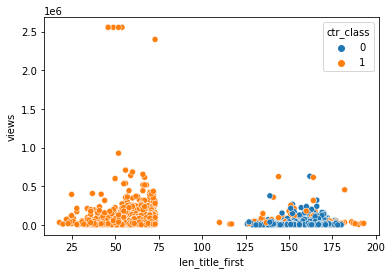

In [197]:
train['ctr_class'] = 0
train.loc[train['ctr']>0,'ctr_class']=1

sns.scatterplot(data=train, x='len_title_first', y='views', hue='ctr_class')

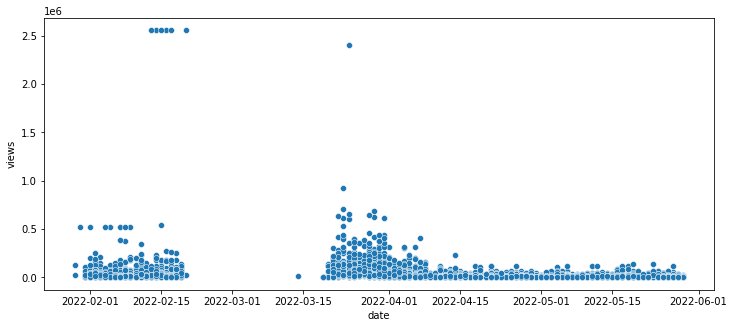

In [198]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=train[train['date']>='2022'], x='date', y='views', 
                
                )

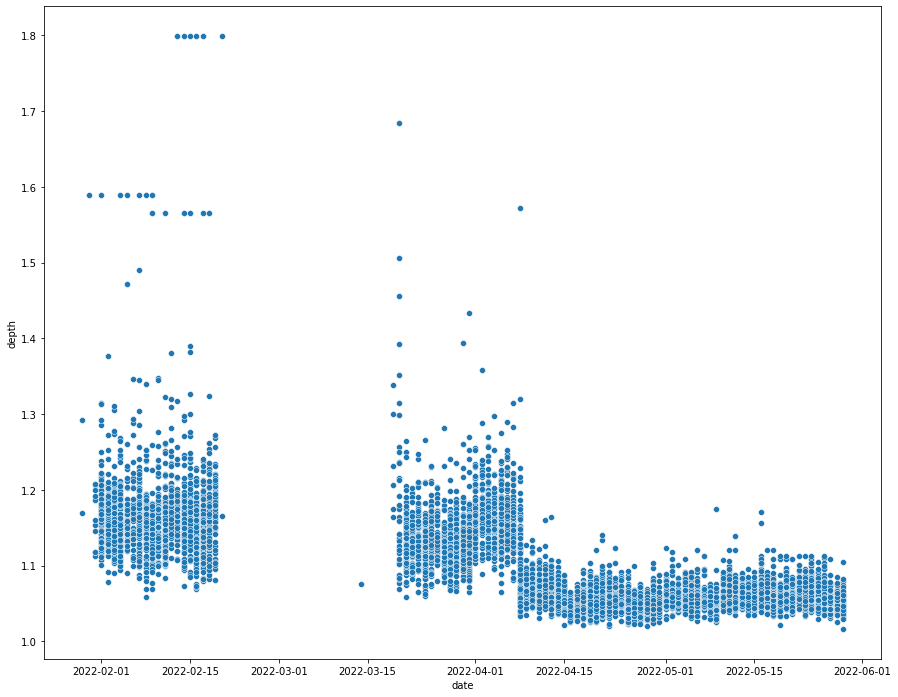

In [199]:
plt.figure(figsize=(15,12))
sns.scatterplot(data=train[train['date']>'2022'], x='date', y='depth', 
                
                )

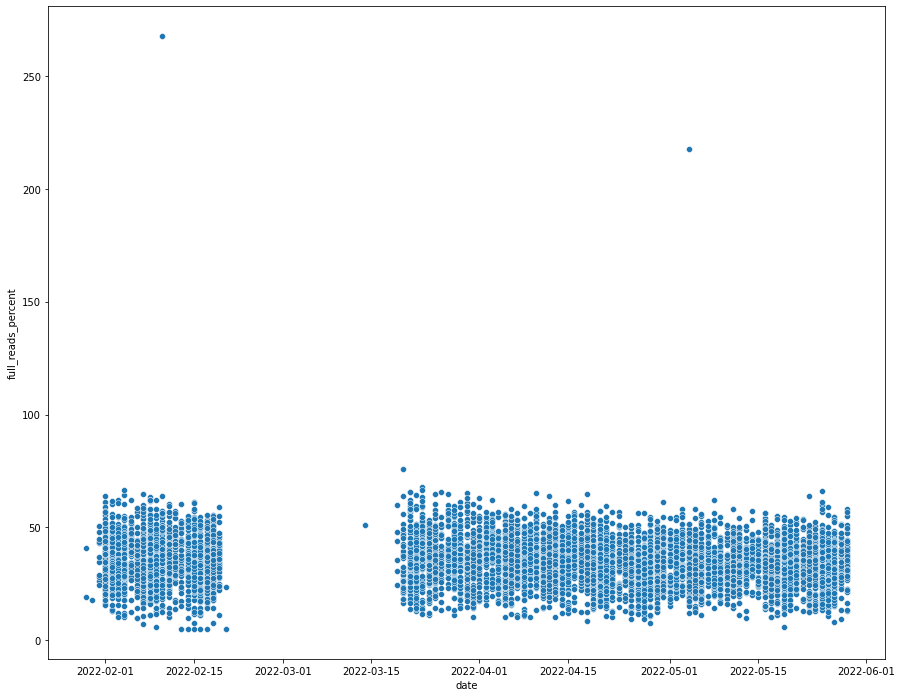

In [200]:
plt.figure(figsize=(15,12))
sns.scatterplot(data=train[train['date']>'2022'], x='date', y='full_reads_percent', 
                
                )

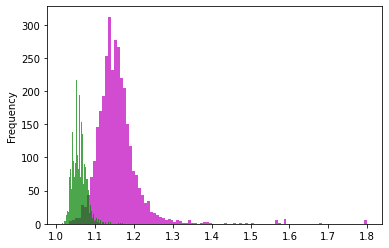

In [201]:
ax = train[train['date']<='2022-04-08']['depth'].plot(kind='hist', bins=100, color='m', alpha=0.7)
train[train['date']>'2022-04-08']['depth'].plot(kind='hist', bins=100, ax=ax, color='g', alpha=0.7)



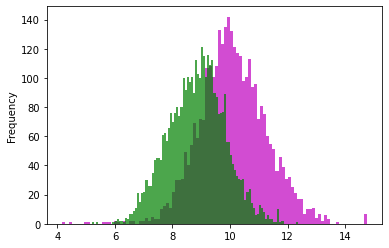

In [202]:
ax = np.log(train[train['date']<='2022-04-08']['views']).plot(kind='hist', bins=100, color='m', alpha=0.7)
np.log(train[train['date']>'2022-04-08']['views']).plot(kind='hist', bins=100, ax=ax, color='g', alpha=0.7)



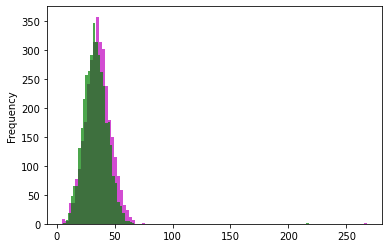

In [203]:
ax = train[train['date']<='2022-04-08']['full_reads_percent'].plot(kind='hist', bins=100, color='m', alpha=0.7)
train[train['date']>'2022-04-08']['full_reads_percent'].plot(kind='hist', bins=100, ax=ax, color='g', alpha=0.7)



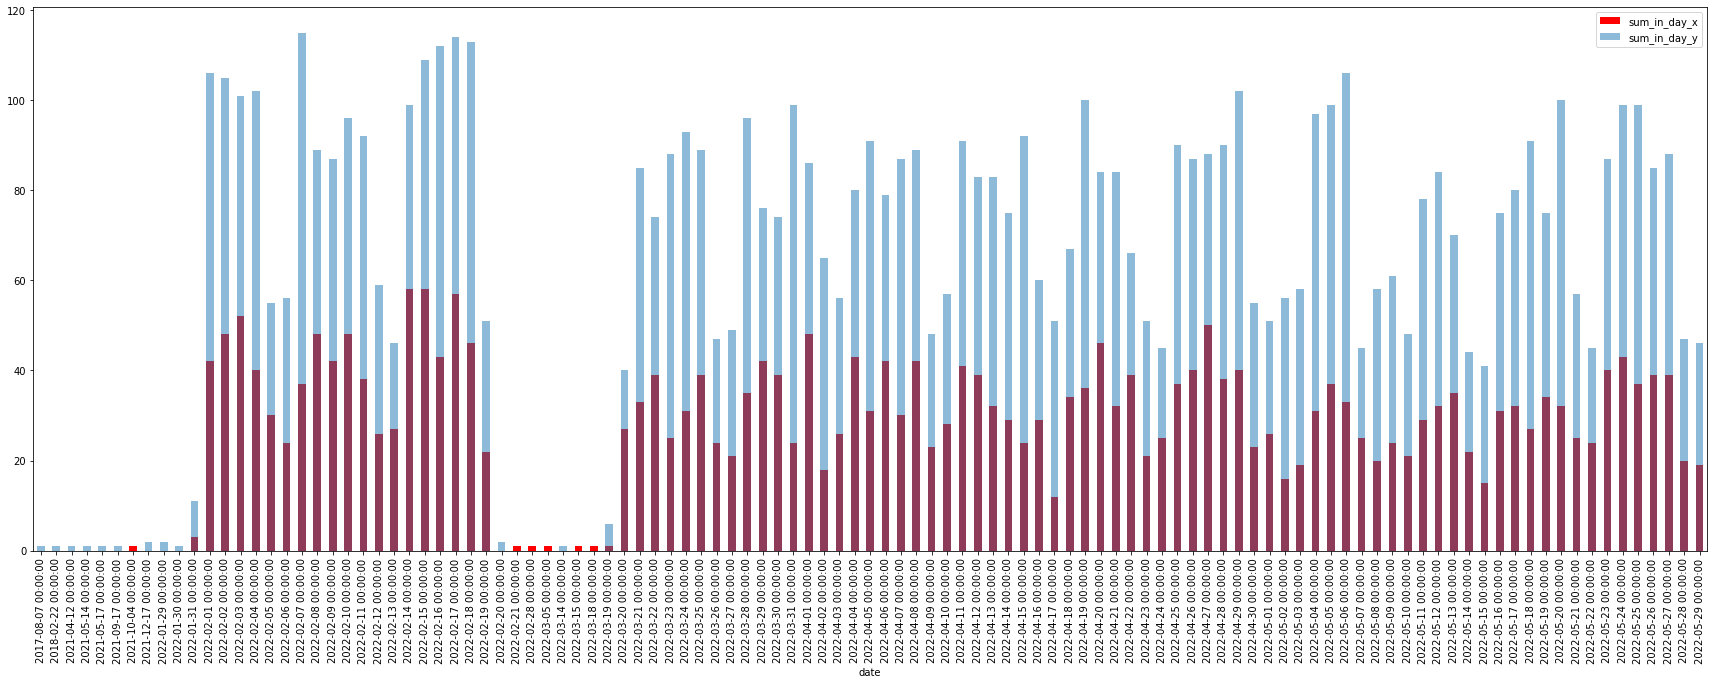

In [204]:
rt = train.groupby('date')['date'].count()
rt = rt.reset_index(name = 'sum_in_day')
rt_test = test.groupby('date')['date'].count()
rt_test = rt_test.reset_index(name = 'sum_in_day')
rt_all = pd.merge(rt_test, rt, how='outer',left_on=['date'], right_on=['date']).sort_values(by='date')
ax = rt_all.plot(kind='bar', x='date', y = 'sum_in_day_x', figsize=(30,10), color='r')
rt_all.plot(kind='bar', x='date', y = 'sum_in_day_y', figsize=(30,10),alpha=0.5, ax=ax)
plt.show()

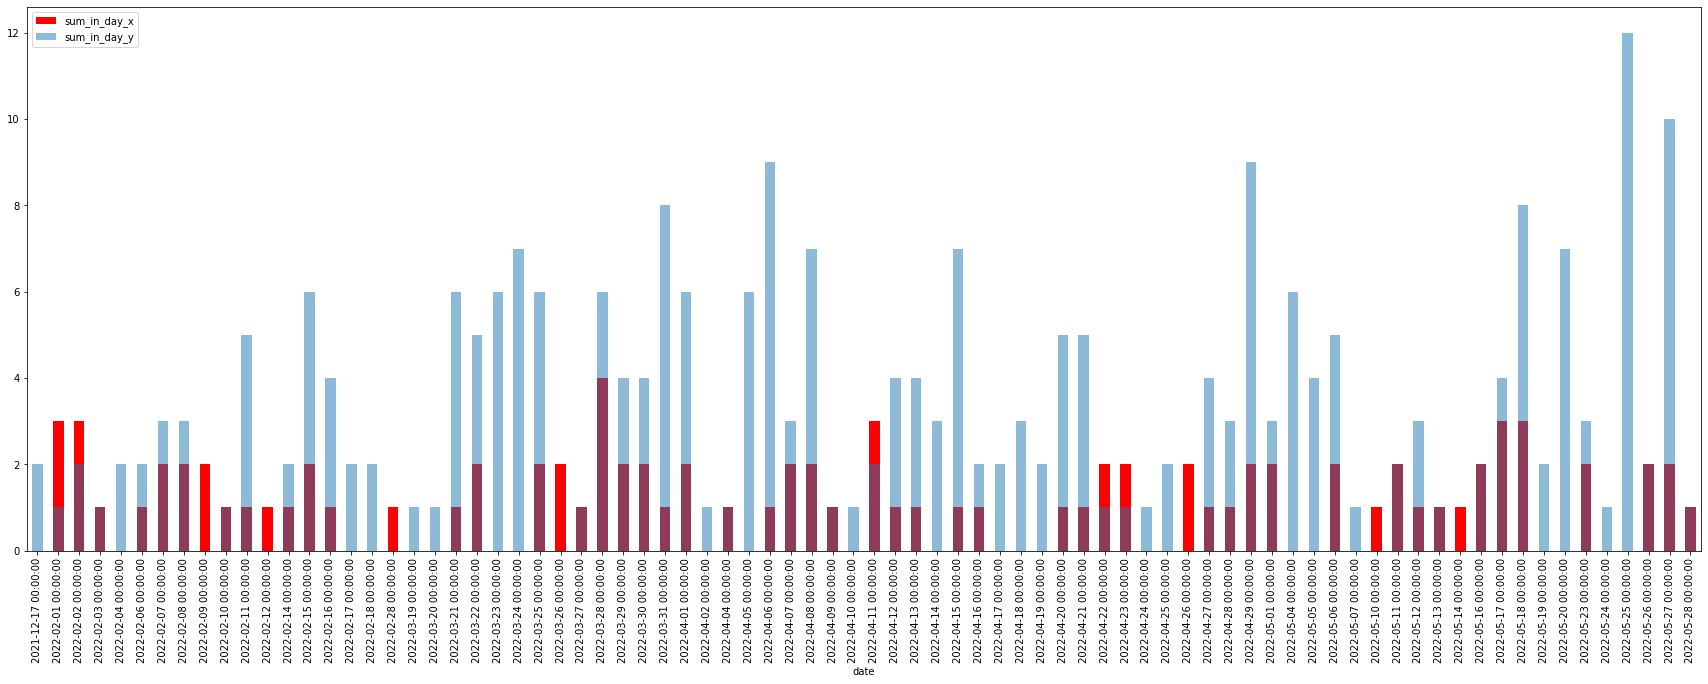

In [205]:
cat =2

rt = train[train['category']==cat].groupby('date')['date'].count()
rt = rt.reset_index(name = 'sum_in_day')
rt_test = test[test['category']==cat].groupby('date')['date'].count()
rt_test = rt_test.reset_index(name = 'sum_in_day')
rt_all = pd.merge(rt_test, rt, how='outer',left_on=['date'], right_on=['date']).sort_values(by='date')
ax = rt_all.plot(kind='bar', x='date', y = 'sum_in_day_x', figsize=(30,10), color='r')
rt_all.plot(kind='bar', x='date', y = 'sum_in_day_y', figsize=(30,10),alpha=0.5, ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


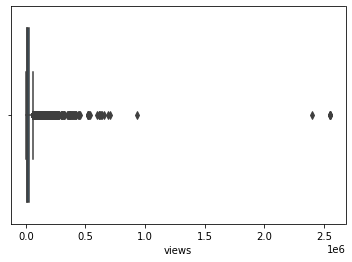

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


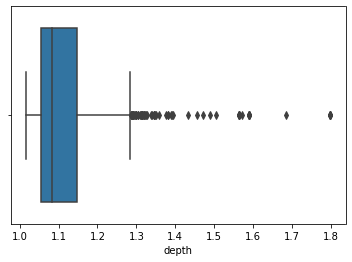

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


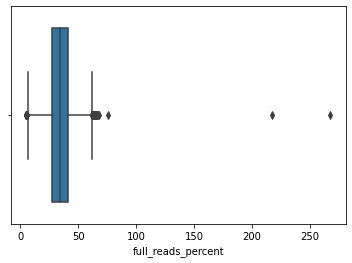

In [532]:
for i in ['views', 'depth', 'full_reads_percent']:
  sns.boxplot(train[i])
  plt.show()

### Вывод
Судя по длине заголовков и кликабельности, новости с разных страниц или вроде того. 8 апреля наблюдается явный сдвиг

# Расчет

Так как в целевых переменных много выбросов и метрика R2, будет сложно настроить валидацию. 

Попробуем определить аутлаеры и валидироваться на данных без них, то есть обучаемся на всех данных, а валидируемся на фолде, очищенном от аутлаеров. Таким образом, мы учимся предсказывать "нормальные" данные.

Так же разделим выборки по длине заголовка, так как предполагаю, что условия просмотров разные.

## Разделим выборки
Надо поменять названия, train_do_08 вводит в заблуждение, так как к датам не имеет никакого отношения.

Отбросим слишком давние статьи

In [206]:
train = train[train['publish_date']>'2021-09-15']

In [207]:
train_do_08 = train[train['len_title_first']<=75]
train_after_08 = train[train['len_title_first']>75]

train_do_08.shape, train_after_08.shape

((3979, 135), (3016, 135))

In [208]:
test_do_08 = test[test['len_title_first']<=75]
test_after_08 = test[test['len_title_first']>75]

test_do_08.shape, test_after_08.shape

((1745, 127), (1255, 127))

In [209]:
train_do_08 = train_do_08.reset_index()
train_after_08 = train_after_08.reset_index()

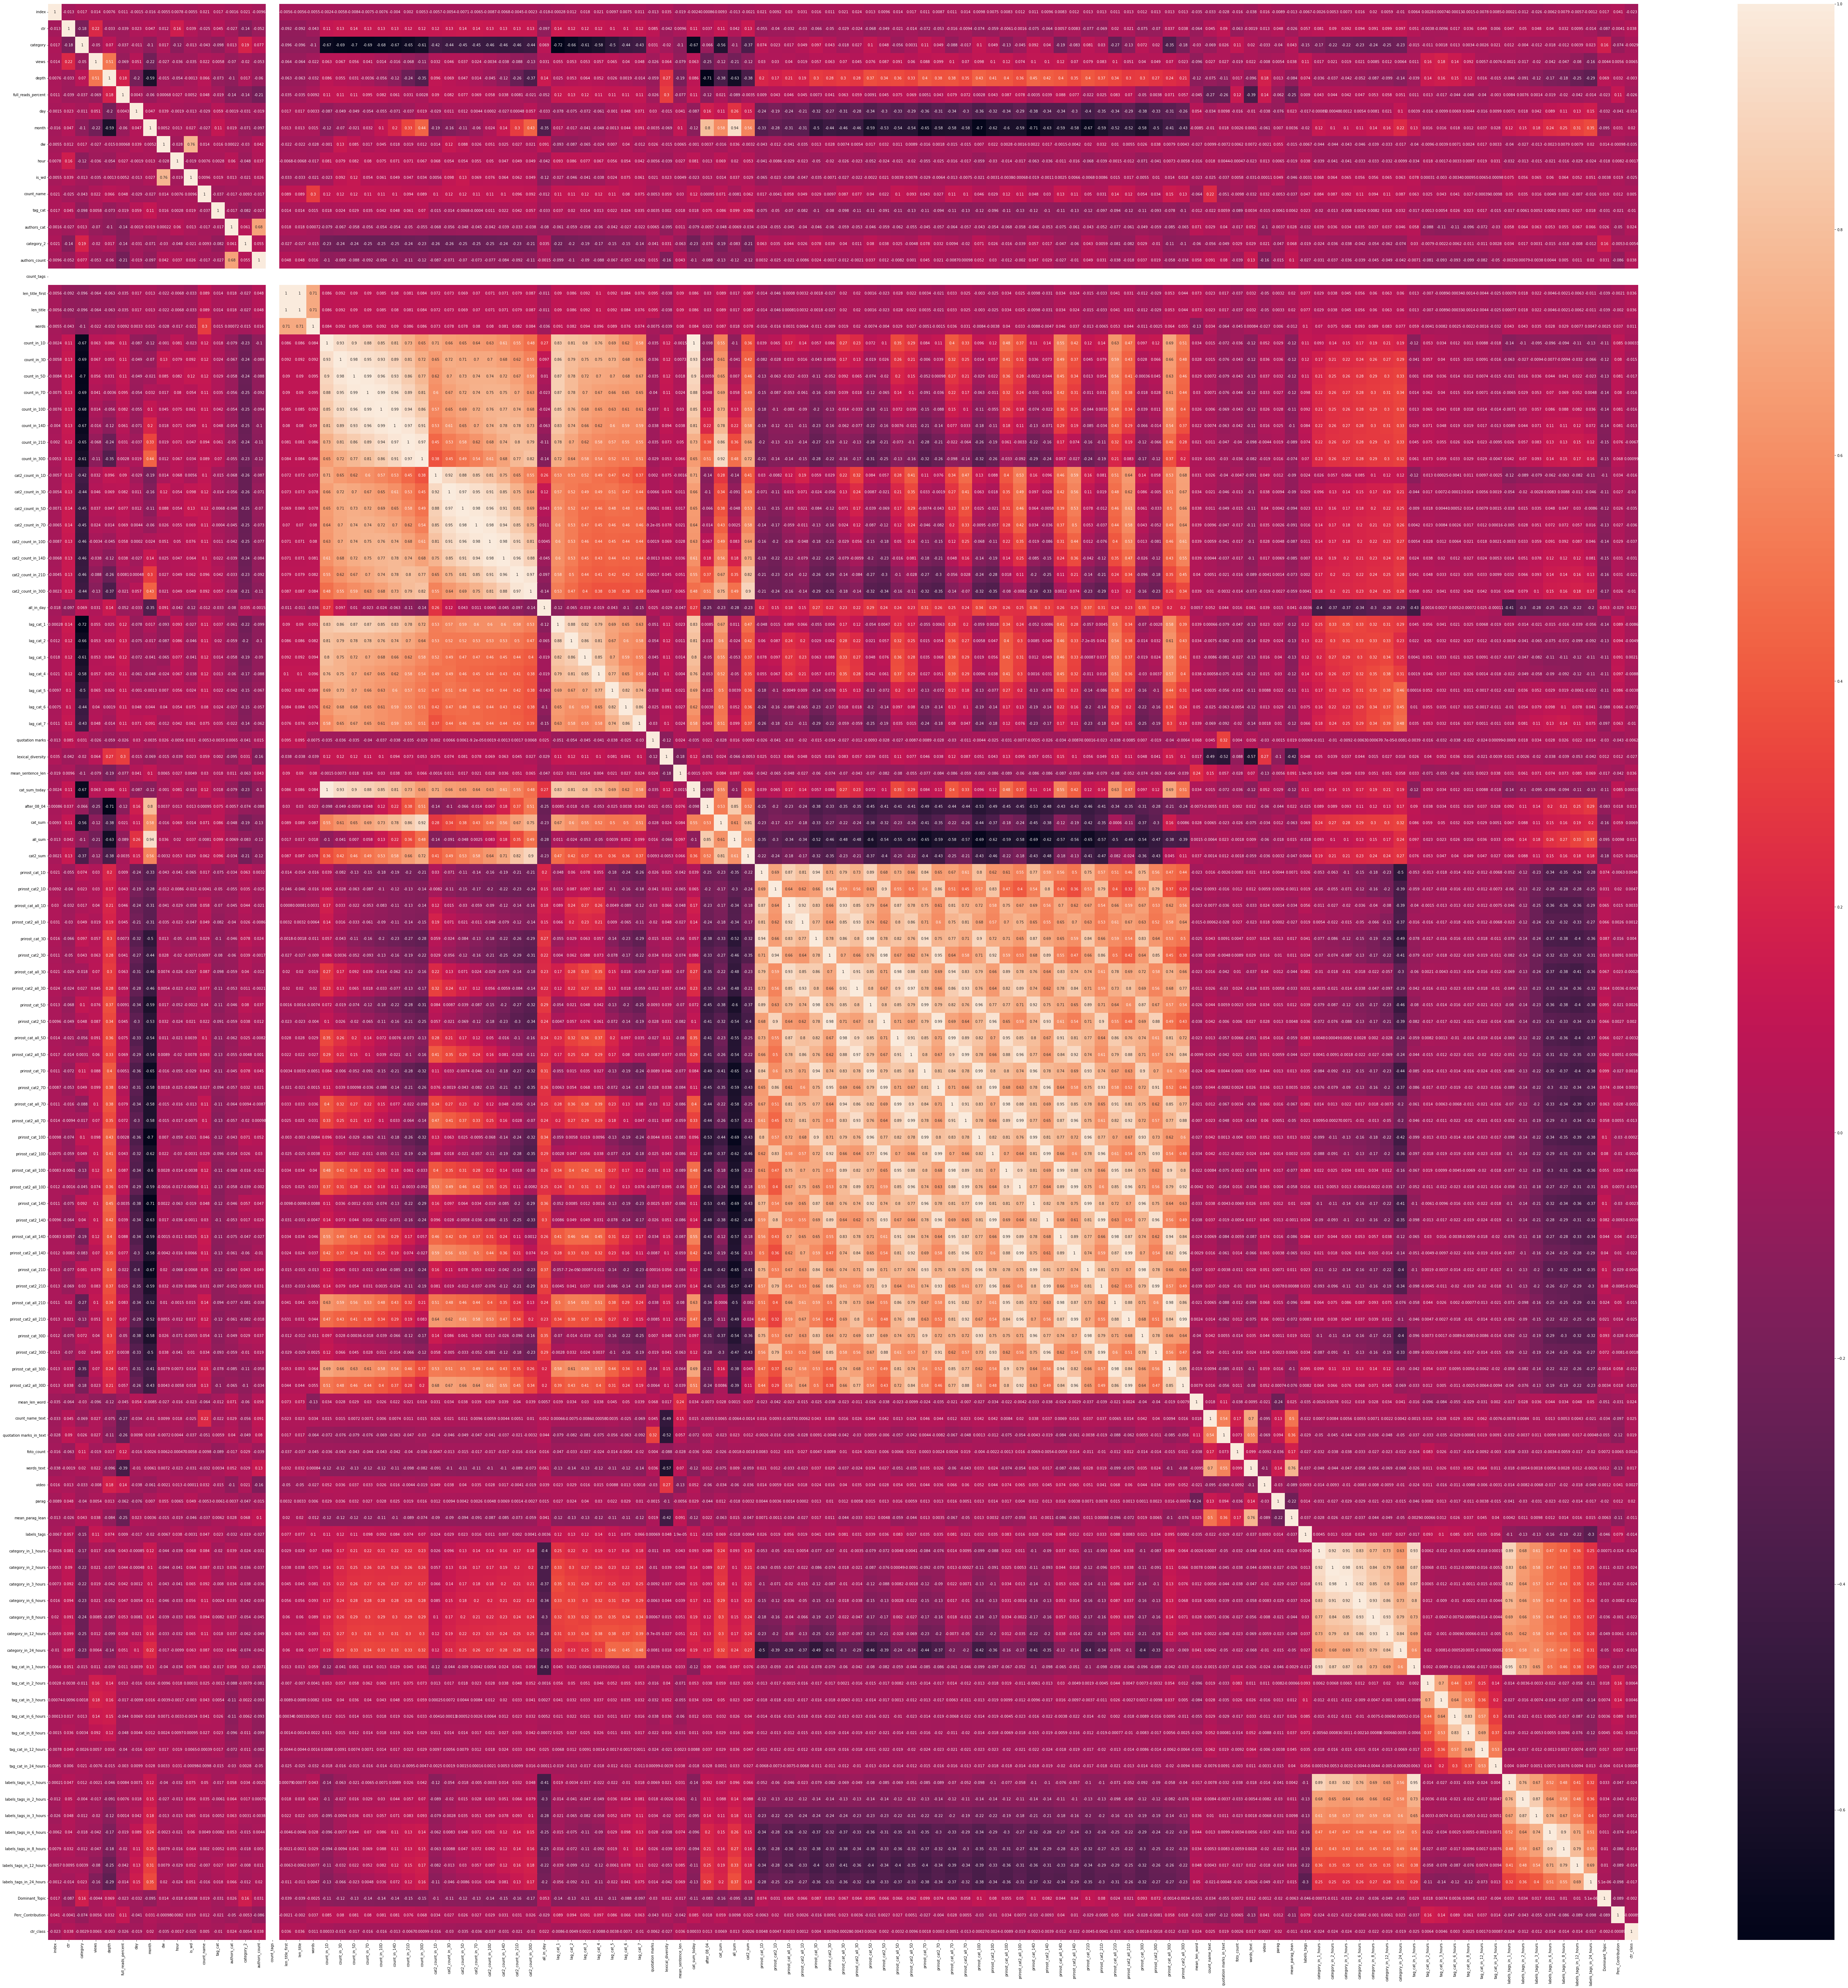

In [210]:
plt.figure(figsize=(100,100))
sns.heatmap(train_do_08.corr(),annot = True)

## Views

### Определим выбросы
Обучим ненастроенную модель и посмотрим где больше всего ошибаемся, то и выброс

In [211]:
cols = ['ctr','category','category_2','month',
        'dw', 'hour', 'count_name','author_1',
       'authors_count', 'count_tags', 'len_title_first', 
     
        'words','quotation marks',  
       'foto_count', 'words_text', 'quotation marks_in_text','all_sum',]

cat_features = ['category', 
                'category_2',
       'month',
        'dw', 'hour',
      
        'author_1',

       ]




In [212]:
# функция для кроссалидации для определения аутлаеров
def cross_val_kfold_out(df, model, params, cols, target_col):


    imp_df = pd.DataFrame()
    res_df = pd.DataFrame(columns=['nums', 'results'])
    results = []

    kf = KFold(n_splits=3, random_state=None)
    n = 0
    for tra_idx, val_idx in kf.split(df):
        n += 1
        # выборки

        x_train = df[cols].iloc[tra_idx]
        y_train = df[target_col].iloc[tra_idx]



        # модель
        model.fit(x_train, y_train, **params, eval_set = (df[cols].iloc[val_idx],df[target_col].iloc[val_idx]))
        res = model.predict(df[cols].iloc[val_idx])


        # результаты

        importances = model.feature_importances_
        df_importances = pd.DataFrame(index=x_train[cols].columns, columns=['importance'], data=importances)
        df_importances = df_importances.sort_values(by='importance',ascending=False)
        imp_df[f'fold_{n}'] = df_importances.index
        imp_df[f'fold_{n}_imp'] = df_importances['importance'].to_list()

        temp_df = pd.DataFrame({'nums':val_idx, 'results':res})
        res_df = res_df.append(temp_df, ignore_index=True)

        r2 = r2_score(df[target_col].iloc[val_idx],res)

        results.append(r2)

    return results, res_df, imp_df


In [213]:

model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    verbose=100, 
   cat_features=cat_features,
   random_seed=4213
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'views'

res, res_views, impot_views = cross_val_kfold_out(train_do_08, model_cat, params, cols, target_col)

Learning rate set to 0.059347
0:	learn: 139973.2283699	test: 61834.0344014	best: 61834.0344014 (0)	total: 68.8ms	remaining: 1m 8s
100:	learn: 68888.6182495	test: 49708.4664992	best: 49491.5662515 (89)	total: 1.45s	remaining: 12.9s
200:	learn: 50248.3796329	test: 47330.4143391	best: 47330.4143391 (200)	total: 2.12s	remaining: 8.41s
300:	learn: 40003.7974120	test: 45402.2956036	best: 45402.2956036 (300)	total: 2.82s	remaining: 6.56s
400:	learn: 33950.7543939	test: 44553.2183550	best: 44553.2183550 (400)	total: 3.55s	remaining: 5.3s
500:	learn: 29951.3657805	test: 44217.0901046	best: 44216.4343011 (479)	total: 4.26s	remaining: 4.25s
600:	learn: 27644.7365273	test: 43922.3442557	best: 43920.2423134 (582)	total: 4.94s	remaining: 3.28s
700:	learn: 25756.9002128	test: 43727.8425208	best: 43720.4234150 (679)	total: 5.69s	remaining: 2.43s
800:	learn: 24208.4109942	test: 43569.4994561	best: 43569.4994561 (800)	total: 6.4s	remaining: 1.59s
900:	learn: 22290.4885500	test: 43459.7996090	best: 43429

In [214]:
res, np.mean(res)

([0.5247050624755011, 0.5549345552946363, 0.49272526512883164],
 0.5241216276329898)

In [215]:

res_views['views'] = train_do_08['views'].reset_index(drop=True)
r2_score(res_views['views'],res_views['results'])


0.5211370526621131

In [216]:
# порог отбрасываемых данных
abs_train_error = np.absolute(res_views['views'] - res_views['results'])
outlier_mask_views_do_08 = (abs_train_error > 95000)
(float(res_views[outlier_mask_views_do_08].shape[0]) / res_views.shape[0])*100


3.6189997486805727

In [217]:
res_views[outlier_mask_views_do_08].shape[0]

144

### Длина более 75

In [218]:


cols = ['ctr',

       'category',
        'category_2',
       'month',
        'dw', 'hour', 'count_name', 
        'author_1',
       'authors_count', 'count_tags',
        'len_title_first', 
        'words',
        'quotation marks',  
       'foto_count', 'words_text', 'quotation marks_in_text',
        'all_sum',
     

        ]

cat_features = ['category', 
                'category_2',      
       'month',
        'dw', 'hour',

        'author_1',

       ]




In [219]:

model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    verbose=100, 
   cat_features=cat_features,
   random_seed=4213
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'views'

res, res_views, impot_views = cross_val_kfold_out(train_after_08, model_cat, params, cols, target_col)

Learning rate set to 0.05682
0:	learn: 34585.6700182	test: 33402.1860676	best: 33402.1860676 (0)	total: 7.63ms	remaining: 7.62s
100:	learn: 19304.7476419	test: 26237.4134115	best: 26229.9330621 (98)	total: 595ms	remaining: 5.29s
200:	learn: 17003.7605560	test: 26322.0868744	best: 25957.6116434 (138)	total: 1.1s	remaining: 4.39s
300:	learn: 15034.4987534	test: 26255.5774132	best: 25957.6116434 (138)	total: 1.69s	remaining: 3.92s
400:	learn: 13649.6977234	test: 26338.8204961	best: 25957.6116434 (138)	total: 2.26s	remaining: 3.37s
500:	learn: 12278.6599951	test: 26337.4576493	best: 25957.6116434 (138)	total: 2.88s	remaining: 2.87s
600:	learn: 11327.9646886	test: 26347.7926664	best: 25957.6116434 (138)	total: 3.51s	remaining: 2.33s
700:	learn: 10723.5315797	test: 26315.0502088	best: 25957.6116434 (138)	total: 4.1s	remaining: 1.75s
Stopped by overfitting detector  (600 iterations wait)

bestTest = 25957.61164
bestIteration = 138

Shrink model to first 139 iterations.
Learning rate set to 0.

In [220]:
res, np.mean(res)

([0.41234748914457364, 0.577951351591302, 0.5589607565892056],
 0.5164198657750271)

In [221]:

res_views['views'] = train_after_08['views'].reset_index(drop=True)
r2_score(res_views['views'],res_views['results'])


0.5188197621002151

In [222]:

abs_train_error = np.absolute(res_views['views'] - res_views['results'])
outlier_mask_views_after_08 = (abs_train_error > 37000)
(float(res_views[outlier_mask_views_after_08].shape[0]) / res_views.shape[0])*100



4.409814323607427

In [223]:
res_views[outlier_mask_views_after_08].shape[0]

133

### Расчет views

In [224]:
# функция для кроссвалидации без аутлаеров
def cross_val_kfold(df, model, params, cols, target_col, outlier_mask):
    outlier_list = df[outlier_mask].index
    
    # q999 = df[target_col].quantile(0.99)
    # df = df[df[target_col]<q999]

    imp_df = pd.DataFrame()
    res_df = pd.DataFrame(columns=['nums', 'results'])
    results = []

    kf = KFold(n_splits=3, random_state=None)
    n = 0
    for tra_idx, val_idx in kf.split(df):
        n += 1
        # выборки

        x_train = df[cols].iloc[tra_idx]
        y_train = df[target_col].iloc[tra_idx]

        x_val = df[cols].iloc[val_idx]
        y_val = df[target_col].iloc[val_idx]

        x_val = x_val[~x_val.index.isin(outlier_list)]
        y_val = y_val[~y_val.index.isin(outlier_list)]

        # y_train = y_train.loc[y_train<=q999]
        # x_train = x_train.loc[y_train.index]

        # модель
        model.fit(x_train, y_train, **params, eval_set = (x_val,y_val))
        res = model.predict(x_val)


        # результаты

        importances = model.feature_importances_
        df_importances = pd.DataFrame(index=x_train[cols].columns, columns=['importance'], data=importances)
        df_importances = df_importances.sort_values(by='importance',ascending=False)
        imp_df[f'fold_{n}'] = df_importances.index
        imp_df[f'fold_{n}_imp'] = df_importances['importance'].to_list()

        temp_df = pd.DataFrame({'nums':x_val.index, 'results':res})
        res_df = res_df.append(temp_df, ignore_index=True)

        r2 = r2_score(y_val,res)

        results.append(r2)

    return results, res_df, imp_df

#### Длина менеее 75

In [225]:
train_do_08['Dominant_Topic'] = train_do_08['Dominant_Topic'].astype('int')
train_after_08['Dominant_Topic'] = train_after_08['Dominant_Topic'].astype('int')

test_do_08['Dominant_Topic'] = test_do_08['Dominant_Topic'].astype('int')
test_after_08['Dominant_Topic'] = test_after_08['Dominant_Topic'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [392]:

# cols = ['ctr',
#         'dw',
#         'hour',

#        'authors_count', 
#         'count_tags', 

#         'words',
       
#        'foto_count',
#         'words_text', 

#         'all_sum',


#         'labels_tags',
        


#          'Dominant_Topic'


        
     

#         ]

# cat_features = [

#         'dw', 
#         'hour',

#         'labels_tags',

#         'Dominant_Topic'

#        ]


cols = ['ctr',
        'dw',
        'hour',
       'authors_count', 
        'count_tags', 
        'len_title_first', 
        'words',
       'foto_count',
        'words_text', 
        'all_sum',

        'labels_tags',

        


        
     

        ]

cat_features = [
        'dw', 
        'hour',
        'labels_tags',
        

       ]









In [405]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 6,
    verbose=100, 
   cat_features=cat_features,
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'views'
res, res_views_do_08, impot_views_do_08 = cross_val_kfold(train_do_08, model_cat, params, cols, target_col, outlier_mask_views_do_08)

Learning rate set to 0.025477
0:	learn: 141629.3331224	test: 44569.6451224	best: 44569.6451224 (0)	total: 20.8ms	remaining: 1m 23s
100:	learn: 92445.8785553	test: 33213.2262977	best: 33213.2262977 (100)	total: 2.12s	remaining: 1m 21s
200:	learn: 70706.9842134	test: 30711.4956377	best: 30711.4956377 (200)	total: 4.12s	remaining: 1m 17s
300:	learn: 63449.9989208	test: 30404.7412060	best: 30352.9888428 (296)	total: 5.29s	remaining: 1m 5s
400:	learn: 57222.1684673	test: 29913.1214866	best: 29895.9914553 (388)	total: 6.62s	remaining: 59.4s
500:	learn: 53610.6739224	test: 29837.6810559	best: 29795.0410905 (430)	total: 7.65s	remaining: 53.4s
600:	learn: 51258.8294296	test: 30142.4338882	best: 29795.0410905 (430)	total: 8.4s	remaining: 47.5s
700:	learn: 48265.1230297	test: 30026.3762823	best: 29795.0410905 (430)	total: 9.59s	remaining: 45.1s
800:	learn: 46225.2702738	test: 29565.9325649	best: 29541.6463443 (791)	total: 10.7s	remaining: 42.5s
900:	learn: 44131.7521191	test: 29691.9828903	best: 

In [406]:
res, np.mean(res)

([0.5866565108707391, 0.8320852288629943, 0.624466692255688],
 0.6810694773298072)

In [407]:
train_views_do_08 = train_do_08[~outlier_mask_views_do_08]
res_views_do_08['views'] = train_views_do_08['views'].reset_index(drop=True)
r2_score(res_views_do_08['views'],res_views_do_08['results'])

0.7545996327675194

In [335]:
impot_views_do_08

fold_1  fold_1_imp           fold_2  fold_2_imp           fold_3  \
0               ctr   29.068232              ctr   22.503582          all_sum   
1           all_sum   20.958968          all_sum   22.224299              ctr   
2        words_text   12.366000      labels_tags   14.694641       words_text   
3       labels_tags   11.881378       foto_count   11.689247       foto_count   
4     authors_count    6.527214  len_title_first    8.374972      labels_tags   
5   len_title_first    6.418089    authors_count    7.180213    authors_count   
6        foto_count    4.776158             hour    5.876787  len_title_first   
7             words    4.104402               dw    2.971165             hour   
8              hour    2.311177            words    2.251919            words   
9                dw    1.588381       words_text    2.233175               dw   
10       count_tags    0.000000       count_tags    0.000000       count_tags   

    fold_3_imp  
0    34.795321  
1    29.440709  
2    11.223135  
3     6.997893  
4     4.815221  
5     3.557469  
6     3.159864  
7     2.940799  
8     1.748878  
9     1.320710  
10    0.000000

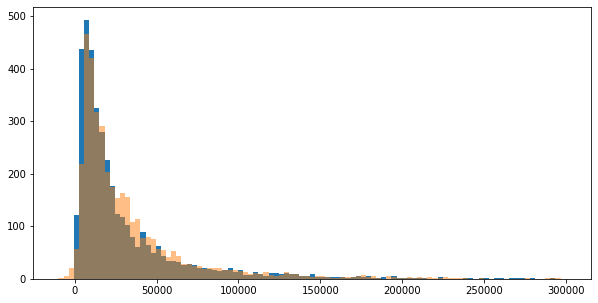

In [410]:
plt.figure(figsize=(10,5))
bins = np.linspace(-10000, 300000, 100)

plt.hist(res_views_do_08['views'], bins)
plt.hist(res_views_do_08.results, bins, alpha=0.5)
plt.show()

#### Длина более 75

In [411]:


cols = [
        'ctr',

       'category',
        'category_2',
        'dw', 'hour', 

       'authors_count', 'count_tags', 

        'words',

        'quotation marks_in_text',

     'all_sum',

     'labels_tags',
        ]

cat_features = [
                'category', 
                'category_2',
        'dw', 'hour',
        'labels_tags',
       ]






In [424]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 10,
    verbose=100, 
   cat_features=cat_features,
  #  learning_rate = 0.01
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600
    }


target_col = 'views'
res, res_views_after_08, impot_views_after_08 = cross_val_kfold(train_after_08, model_cat, params, cols, target_col, outlier_mask_views_after_08)

Learning rate set to 0.024392
0:	learn: 35015.2765475	test: 14468.3699259	best: 14468.3699259 (0)	total: 122ms	remaining: 8m 6s
100:	learn: 23058.2819701	test: 9644.2448464	best: 9638.2175224 (98)	total: 4.72s	remaining: 3m 2s
200:	learn: 19624.0262592	test: 9384.5851827	best: 9379.1098199 (199)	total: 9.69s	remaining: 3m 3s
300:	learn: 17457.4549811	test: 9220.2995933	best: 9220.2995933 (300)	total: 15.2s	remaining: 3m 6s
400:	learn: 15736.1573496	test: 9077.8413780	best: 9077.1672570 (398)	total: 20.3s	remaining: 3m 1s
500:	learn: 14076.4733107	test: 9019.0467145	best: 9010.5422355 (494)	total: 25.3s	remaining: 2m 56s
600:	learn: 12817.5786385	test: 9019.8289211	best: 8992.0397311 (528)	total: 30.4s	remaining: 2m 52s
700:	learn: 11926.9699590	test: 8993.6004668	best: 8985.3636421 (677)	total: 33.3s	remaining: 2m 36s
800:	learn: 10969.4493341	test: 8979.2899195	best: 8976.3629279 (798)	total: 35.7s	remaining: 2m 22s
900:	learn: 10115.4191883	test: 8956.9268357	best: 8949.3178420 (835)

In [425]:
res, np.mean(res)

([0.5840817975257357, 0.49293549219875843, 0.5979980051267793],
 0.5583384316170912)

In [426]:
train_views_after_08 = train_after_08[~outlier_mask_views_after_08]
res_views_after_08['views'] = train_views_after_08['views'].reset_index(drop=True)
res_views_after_08['date'] = train_views_after_08['publish_date'].reset_index(drop=True)
r2_score(res_views_after_08['views'],res_views_after_08['results'])

0.5666793973802451

In [236]:
impot_views_after_08

fold_1  fold_1_imp                   fold_2  fold_2_imp  \
0                   all_sum   47.486321                  all_sum   46.513685   
1                       ctr   18.105578               category_2   14.741512   
2   quotation marks_in_text    8.076497                      ctr   11.390353   
3                category_2    7.887969              labels_tags   10.621418   
4               labels_tags    5.051667  quotation marks_in_text    7.765360   
5                  category    4.660841                    words    2.419121   
6                      hour    3.247034                     hour    2.336817   
7             authors_count    2.010022            authors_count    2.029297   
8                        dw    1.954825                 category    1.796381   
9                     words    1.519247                       dw    0.386056   
10               count_tags    0.000000               count_tags    0.000000   

                     fold_3  fold_3_imp  
0                   all_sum   40.815953  
1                       ctr   15.520374  
2                category_2   10.482053  
3   quotation marks_in_text    9.209472  
4               labels_tags    8.226103  
5                      hour    4.689093  
6                        dw    3.934965  
7                  category    3.580728  
8             authors_count    1.833198  
9                     words    1.708061  
10               count_tags    0.000000

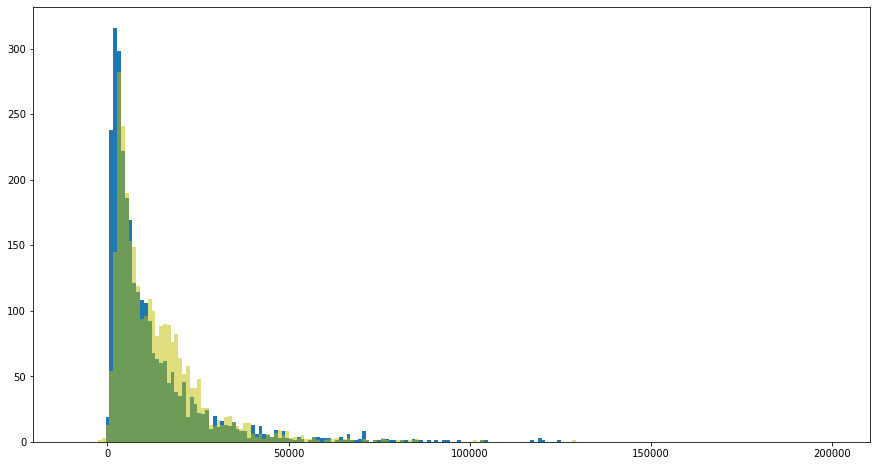

In [427]:
plt.figure(figsize=(15,8))
bins = np.linspace(-10000, 200000, 200)

plt.hist(res_views_after_08['views'], bins)
plt.hist(res_views_after_08.results, bins, alpha=0.5, color='y')
plt.show()

In [428]:
res_views_all = pd.concat([res_views_do_08, res_views_after_08])
R2_views = r2_score(res_views_all['views'],res_views_all['results'])
R2_views

0.7561052895291732

## Depth

### Выбросы





#### Длина менее 75

In [340]:

cols = ['ctr',

       'category',

       'month',
        'dw', 'hour', 'count_name', 

        'author_1',
       'authors_count', 'count_tags', 'len_title',
        'len_title_first', 
        'words',
        'quotation marks',  
       'foto_count', 'words_text', 'quotation marks_in_text',
     

        ]

cat_features = ['category', 
       'month',
        'dw', 'hour',
    
    
        'author_1',
       ]


      

In [341]:

model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    verbose=100, 
   cat_features=cat_features,
   random_seed=1342
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'depth'

res, res_depth, impot_depth = cross_val_kfold_out(train_do_08, model_cat, params, cols, target_col)

Learning rate set to 0.059347
0:	learn: 0.0656254	test: 0.0605230	best: 0.0605230 (0)	total: 9.63ms	remaining: 9.62s
100:	learn: 0.0384513	test: 0.0419347	best: 0.0419347 (100)	total: 1.34s	remaining: 11.9s
200:	learn: 0.0353677	test: 0.0414967	best: 0.0414967 (200)	total: 3.07s	remaining: 12.2s
300:	learn: 0.0335840	test: 0.0412662	best: 0.0412412 (290)	total: 4.51s	remaining: 10.5s
400:	learn: 0.0318448	test: 0.0412171	best: 0.0412092 (320)	total: 5.75s	remaining: 8.59s
500:	learn: 0.0303244	test: 0.0411724	best: 0.0411573 (493)	total: 7.22s	remaining: 7.19s
600:	learn: 0.0288403	test: 0.0411940	best: 0.0411342 (572)	total: 8.43s	remaining: 5.6s
700:	learn: 0.0276615	test: 0.0412276	best: 0.0411342 (572)	total: 9.1s	remaining: 3.88s
800:	learn: 0.0265433	test: 0.0412858	best: 0.0411342 (572)	total: 9.71s	remaining: 2.41s
900:	learn: 0.0253149	test: 0.0413116	best: 0.0411342 (572)	total: 10.4s	remaining: 1.14s
999:	learn: 0.0244058	test: 0.0413165	best: 0.0411342 (572)	total: 11s	rema

In [342]:
res, np.mean(res)

([0.5584410092217762, 0.6121102734002584, 0.5626014067580425],
 0.5777175631266923)

In [343]:

res_depth['depth'] = train_do_08['depth']
r2_score(res_depth['depth'],res_depth['results'])

0.5789408870482993

In [344]:
abs_train_error = np.absolute(res_depth['depth'] - res_depth['results'])
outlier_mask_depth_do_08 = (abs_train_error > 0.08)
(float(res_depth[outlier_mask_depth_do_08].shape[0]) / res_depth.shape[0])*100

5.227444081427494

In [244]:
res_depth[outlier_mask_depth_do_08].shape[0]

208

#### Более 75

In [245]:

cols = ['ctr',

       'category',

       'month',
        'dw', 'hour', 'count_name', 

        'author_1',
       'authors_count', 'count_tags', 'len_title',
        'len_title_first', 
     
        'words',
        'quotation marks',  
       'foto_count', 'words_text', 'quotation marks_in_text',
     

        ]

cat_features = ['category', 
       'month',
        'dw', 'hour',
        'author_1',
       ]

In [246]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    verbose=100, 
   cat_features=cat_features,
   random_seed=1342
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'depth'

res, res_depth, impot_depth = cross_val_kfold_out(train_after_08, model_cat, params, cols, target_col)

Learning rate set to 0.05682
0:	learn: 0.0608743	test: 0.0623607	best: 0.0623607 (0)	total: 5.5ms	remaining: 5.49s
100:	learn: 0.0371851	test: 0.0410815	best: 0.0410764 (99)	total: 476ms	remaining: 4.24s
200:	learn: 0.0346669	test: 0.0408118	best: 0.0407862 (184)	total: 994ms	remaining: 3.95s
300:	learn: 0.0325383	test: 0.0407090	best: 0.0406968 (293)	total: 1.51s	remaining: 3.5s
400:	learn: 0.0309263	test: 0.0408023	best: 0.0406935 (312)	total: 2.01s	remaining: 3s
500:	learn: 0.0295392	test: 0.0408613	best: 0.0406935 (312)	total: 2.57s	remaining: 2.56s
600:	learn: 0.0281347	test: 0.0408752	best: 0.0406935 (312)	total: 3.1s	remaining: 2.06s
700:	learn: 0.0268299	test: 0.0408685	best: 0.0406935 (312)	total: 3.64s	remaining: 1.55s
800:	learn: 0.0257234	test: 0.0409305	best: 0.0406935 (312)	total: 4.17s	remaining: 1.03s
900:	learn: 0.0247228	test: 0.0409748	best: 0.0406935 (312)	total: 4.71s	remaining: 517ms
Stopped by overfitting detector  (600 iterations wait)

bestTest = 0.0406935307
b

In [247]:
res, np.mean(res)

([0.596620901933385, 0.5968182647322271, 0.6193715250642937],
 0.6042702305766353)

In [248]:
res_depth['depth'] = train_after_08['depth']
r2_score(res_depth['depth'],res_depth['results'])

0.6045503445593289

In [249]:
abs_train_error = np.absolute(res_depth['depth'] - res_depth['results'])
outlier_mask_depth_after_08 = (abs_train_error > 0.08)
(float(res_depth[outlier_mask_depth_after_08].shape[0]) / res_depth.shape[0])*100

4.807692307692308

In [250]:
impot_depth

fold_1  fold_1_imp                   fold_2  fold_2_imp  \
0                     month   53.304129                    month   50.541838   
1                words_text   14.221669               words_text   15.018555   
2                      hour    5.867911                     hour    6.494427   
3                        dw    4.319729                       dw    6.403685   
4                  category    3.081318                 category    4.513928   
5   quotation marks_in_text    3.080963  quotation marks_in_text    3.920384   
6                  author_1    2.912546               count_name    2.219712   
7                 len_title    2.765999                len_title    1.993187   
8                foto_count    2.394681          len_title_first    1.839327   
9                     words    2.094269                 author_1    1.776966   
10               count_name    1.914840               foto_count    1.601324   
11            authors_count    1.465436                    words    1.577560   
12          len_title_first    1.334344            authors_count    1.329181   
13                      ctr    1.003075                      ctr    0.548086   
14          quotation marks    0.239091          quotation marks    0.221839   
15               count_tags    0.000000               count_tags    0.000000   

                     fold_3  fold_3_imp  
0                     month   50.294362  
1                words_text   13.902818  
2                        dw    8.111192  
3                  category    5.623178  
4   quotation marks_in_text    4.928453  
5                      hour    4.706955  
6                  author_1    2.696171  
7                foto_count    2.174982  
8             authors_count    1.675589  
9                count_name    1.526994  
10                      ctr    1.478986  
11                len_title    1.016336  
12          len_title_first    0.881062  
13                    words    0.804762  
14          quotation marks    0.178160  
15               count_tags    0.000000

### Расчет

#### Длина менее 75

In [429]:

cols = [
        'ctr',
       'category',
        'category_2',
        'dw', 'hour', 'count_name', 

        'author_1',
       'authors_count', 
       'foto_count', 'words_text',
        'quotation marks_in_text',
        'mean_sentence_len', 'lexical_diversity',

        'all_sum', 

        'labels_tags',
        ]

cat_features = [
                'category', 
                'category_2',
        'dw', 'hour',
        'author_1',
        'labels_tags',
        
       ]






In [446]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 6,
    verbose=100, 
   cat_features=cat_features,
   random_seed=1342
   
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}

    
target_col = 'depth'
res, res_depth_do_08, impot_depth_do_08  = cross_val_kfold(train_do_08, model_cat, params, cols, target_col, outlier_mask_depth_do_08)

Learning rate set to 0.025477
0:	learn: 0.0662313	test: 0.0498626	best: 0.0498626 (0)	total: 22.8ms	remaining: 1m 31s
100:	learn: 0.0340063	test: 0.0226675	best: 0.0226675 (100)	total: 2.27s	remaining: 1m 27s
200:	learn: 0.0296236	test: 0.0219791	best: 0.0219791 (200)	total: 3.63s	remaining: 1m 8s
300:	learn: 0.0271710	test: 0.0215298	best: 0.0215298 (300)	total: 5.09s	remaining: 1m 2s
400:	learn: 0.0253613	test: 0.0213973	best: 0.0213973 (400)	total: 6.56s	remaining: 58.8s
500:	learn: 0.0239105	test: 0.0213435	best: 0.0213435 (500)	total: 8.06s	remaining: 56.3s
600:	learn: 0.0227741	test: 0.0213192	best: 0.0213008 (575)	total: 9.64s	remaining: 54.5s
700:	learn: 0.0218919	test: 0.0213436	best: 0.0213008 (575)	total: 11.2s	remaining: 52.7s
800:	learn: 0.0209840	test: 0.0213918	best: 0.0213008 (575)	total: 13s	remaining: 51.9s
900:	learn: 0.0202459	test: 0.0214352	best: 0.0213008 (575)	total: 13.9s	remaining: 47.9s
1000:	learn: 0.0196015	test: 0.0214902	best: 0.0213008 (575)	total: 14.6s

In [447]:
res, np.mean(res)

([0.8185702553371401, 0.8594174611072269, 0.8181530309537695],
 0.832046915799379)

In [448]:
train_depth_do_08 = train_do_08[~outlier_mask_depth_do_08]
train_depth_do_08.shape, res_depth_do_08.shape

((3771, 136), (3771, 2))

In [449]:
res_depth_do_08['depth'] = train_depth_do_08['depth'].reset_index(drop=True)
res_depth_do_08['results'] = res_depth_do_08['results'].round(3)
r2_score(res_depth_do_08['depth'], res_depth_do_08['results'])

0.8342926671406417

In [256]:
impot_depth_do_08.head(30)

fold_1  fold_1_imp                   fold_2  fold_2_imp  \
0                   all_sum   60.903504                  all_sum   61.173442   
1                       ctr    5.436158               words_text    5.832352   
2                words_text    5.295673        lexical_diversity    4.808702   
3         lexical_diversity    4.294798                      ctr    4.108108   
4               labels_tags    3.809791               category_2    3.471141   
5         mean_sentence_len    3.456400              labels_tags    3.301748   
6                foto_count    3.276315                     hour    3.287616   
7                category_2    2.822421                       dw    2.356168   
8             authors_count    2.282158        mean_sentence_len    2.334764   
9                count_name    1.990298                 author_1    1.931268   
10                       dw    1.719422               count_name    1.841642   
11  quotation marks_in_text    1.547704            authors_count    1.799769   
12                 author_1    1.301936               foto_count    1.583687   
13                     hour    1.156469  quotation marks_in_text    1.108633   
14                 category    0.706955                 category    1.060961   

                     fold_3  fold_3_imp  
0                   all_sum   60.357971  
1                words_text    7.367558  
2         lexical_diversity    6.321952  
3               labels_tags    4.610649  
4         mean_sentence_len    3.774821  
5                category_2    3.645398  
6                       ctr    3.168918  
7                count_name    2.180185  
8                      hour    1.929175  
9                foto_count    1.535657  
10                       dw    1.346798  
11                 author_1    1.235066  
12                 category    1.199745  
13  quotation marks_in_text    0.936094  
14            authors_count    0.390014

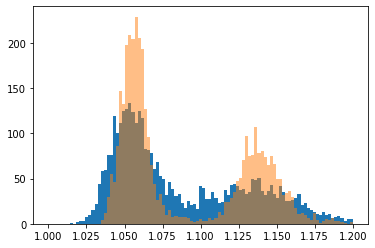

In [450]:
bins = np.linspace(1, 1.2, 100)

plt.hist(res_depth_do_08['depth'], bins)
plt.hist(res_depth_do_08['results'], bins, alpha=0.5)
plt.show()

#### Более 75

In [451]:


cols = [
        'category_2',
        'dw', 'hour', 
      
        'words_text',
   
     'mean_sentence_len', 'lexical_diversity',
     'all_sum', 

    'labels_tags']

cat_features = [
                'category_2',
        'dw', 'hour',
        'labels_tags',

       ]





In [464]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 6,
    verbose=100, 
   cat_features=cat_features,
   random_seed=1342
   
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}

    
target_col = 'depth'
res, res_depth_after_08, impot_depth_after_08  = cross_val_kfold(train_after_08, model_cat, params, cols, target_col, outlier_mask_depth_after_08)

Learning rate set to 0.024392
0:	learn: 0.0616402	test: 0.0562374	best: 0.0562374 (0)	total: 22.6ms	remaining: 1m 30s
100:	learn: 0.0288752	test: 0.0234687	best: 0.0234687 (100)	total: 1.24s	remaining: 48s
200:	learn: 0.0258854	test: 0.0220360	best: 0.0220360 (200)	total: 2.4s	remaining: 45.5s
300:	learn: 0.0245375	test: 0.0217102	best: 0.0217036 (294)	total: 3.55s	remaining: 43.6s
400:	learn: 0.0234023	test: 0.0215066	best: 0.0215055 (399)	total: 4.64s	remaining: 41.6s
500:	learn: 0.0225423	test: 0.0214439	best: 0.0214329 (469)	total: 5.47s	remaining: 38.2s
600:	learn: 0.0217804	test: 0.0214080	best: 0.0213760 (557)	total: 6.41s	remaining: 36.3s
700:	learn: 0.0211253	test: 0.0214295	best: 0.0213760 (557)	total: 7.59s	remaining: 35.7s
800:	learn: 0.0204301	test: 0.0214269	best: 0.0213760 (557)	total: 8.78s	remaining: 35.1s
900:	learn: 0.0198554	test: 0.0214308	best: 0.0213760 (557)	total: 10s	remaining: 34.4s
1000:	learn: 0.0193099	test: 0.0214477	best: 0.0213760 (557)	total: 11.1s	rem

In [466]:
res, np.mean(res)

([0.8605170988107311, 0.8385968320147117, 0.8530399667604074],
 0.85071796586195)

In [467]:
train_depth_after_08 = train_after_08[~outlier_mask_depth_after_08]
train_depth_after_08.shape, res_depth_after_08.shape

((2871, 136), (2871, 2))

In [468]:
res_depth_after_08['depth'] = train_depth_after_08['depth'].reset_index(drop=True)
res_depth_after_08['results'] = res_depth_after_08['results'].round(3)
r2_score(res_depth_after_08['depth'], res_depth_after_08['results'])

0.8507302747458989

In [469]:
impot_depth_after_08


fold_1  fold_1_imp             fold_2  fold_2_imp  \
0            all_sum   75.203679            all_sum   72.425265   
1         words_text    7.586609         words_text    6.896779   
2         category_2    5.754408         category_2    5.777623   
3  lexical_diversity    4.270047  lexical_diversity    4.675763   
4               hour    2.255474                 dw    2.987081   
5        labels_tags    2.150407  mean_sentence_len    2.684733   
6                 dw    1.682538               hour    2.515382   
7  mean_sentence_len    1.096838        labels_tags    2.037373   

              fold_3  fold_3_imp  
0            all_sum   72.144250  
1         category_2    6.101638  
2         words_text    5.414481  
3  lexical_diversity    5.075800  
4                 dw    3.489882  
5               hour    2.758231  
6  mean_sentence_len    2.742222  
7        labels_tags    2.273497

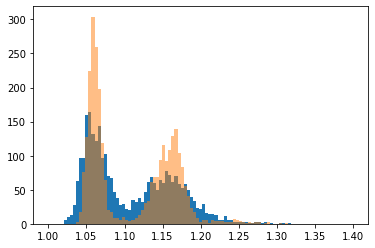

In [470]:
bins = np.linspace(1, 1.4, 100)

plt.hist(res_depth_after_08['depth'], bins)
plt.hist(res_depth_after_08.results, bins, alpha=0.5)
plt.show()

In [471]:
res_depth_all = pd.concat([res_depth_do_08, res_depth_after_08])
R2_depth = r2_score(res_depth_all['depth'],res_depth_all['results'])
R2_depth 

0.846534024077072

## full_reads_percent

### Выбросы

#### Длина менее 75

In [472]:

cols = ['ctr',

       'category',

       'month',
        'dw', 'hour', 'count_name', 

        'author_1',
       'authors_count', 'count_tags', 'len_title',
        'len_title_first', 
    
        'words',
        'quotation marks',  
       'foto_count', 'words_text', 'quotation marks_in_text',
     

        ]

cat_features = ['category', 
      
       'month',
        'dw', 'hour',
        
        'author_1',

       ]

In [267]:
train_frp_do_08 = train_do_08[train_do_08['full_reads_percent']<=100]
train_frp_do_08 = train_frp_do_08.reset_index(drop=True)

In [268]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    verbose=100, 
   cat_features=cat_features,
   random_seed=1342
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'full_reads_percent'

res, res_frp, impot_frp = cross_val_kfold_out(train_frp_do_08, model_cat, params, cols, target_col)

Learning rate set to 0.059343
0:	learn: 9.0040615	test: 9.0537915	best: 9.0537915 (0)	total: 6.69ms	remaining: 6.68s
100:	learn: 6.6600121	test: 6.9502301	best: 6.9502301 (100)	total: 591ms	remaining: 5.26s
200:	learn: 6.2304766	test: 6.8712394	best: 6.8711401 (198)	total: 1.19s	remaining: 4.74s
300:	learn: 5.9388776	test: 6.8544798	best: 6.8497476 (280)	total: 1.78s	remaining: 4.14s
400:	learn: 5.6419730	test: 6.8434070	best: 6.8408754 (337)	total: 3.32s	remaining: 4.96s
500:	learn: 5.3699326	test: 6.8361030	best: 6.8328428 (484)	total: 4.8s	remaining: 4.78s
600:	learn: 5.1429057	test: 6.8393694	best: 6.8266451 (548)	total: 6.02s	remaining: 4s
700:	learn: 4.9298591	test: 6.8550875	best: 6.8266451 (548)	total: 6.6s	remaining: 2.82s
800:	learn: 4.7083370	test: 6.8620305	best: 6.8266451 (548)	total: 7.19s	remaining: 1.79s
900:	learn: 4.5056647	test: 6.8803477	best: 6.8266451 (548)	total: 7.81s	remaining: 858ms
999:	learn: 4.3128713	test: 6.8896129	best: 6.8266451 (548)	total: 8.43s	remai

In [269]:
res, np.mean(res)

([0.4482591280295083, 0.41641957827767373, 0.4217129372399693],
 0.42879721451571706)

In [270]:
res_frp['frp'] = train_frp_do_08['full_reads_percent'].reset_index(drop=True)
r2_score(res_frp['frp'],res_frp['results'])

0.4289688621144083

In [271]:
abs_train_error = np.absolute(res_frp['frp'] - res_frp['results'])
outlier_mask_frp_do_08 = (abs_train_error > 14)
(float(res_frp[outlier_mask_frp_do_08].shape[0]) / res_frp.shape[0])*100

4.1740005028916265

In [272]:
res_frp[outlier_mask_frp_do_08].shape[0]

166

In [273]:
impot_frp

fold_1  fold_1_imp                   fold_2  fold_2_imp  \
0                words_text   26.828614               words_text   35.343703   
1                     month   11.248310                    month    9.424873   
2                  author_1   11.064957                 author_1    8.174649   
3                  category    8.267451                 category    7.871647   
4                      hour    8.221690                     hour    7.298104   
5                       ctr    8.129593                      ctr    6.960674   
6                        dw    5.591306               foto_count    4.771984   
7                foto_count    4.285067                       dw    4.457750   
8             authors_count    3.576034            authors_count    4.370383   
9   quotation marks_in_text    3.343946  quotation marks_in_text    2.645619   
10                len_title    2.768016          len_title_first    2.394413   
11               count_name    2.278175               count_name    2.385128   
12          len_title_first    2.083405                len_title    1.738986   
13                    words    1.795839                    words    1.629593   
14          quotation marks    0.517597          quotation marks    0.532493   
15               count_tags    0.000000               count_tags    0.000000   

                     fold_3  fold_3_imp  
0                words_text   37.161340  
1                  author_1   11.890631  
2                     month    9.409665  
3                  category    7.811726  
4                       ctr    6.244805  
5                foto_count    5.563477  
6                      hour    5.340655  
7             authors_count    4.939062  
8                count_name    2.911097  
9                        dw    2.832645  
10          len_title_first    1.483346  
11                    words    1.341395  
12  quotation marks_in_text    1.244452  
13                len_title    1.129037  
14          quotation marks    0.696669  
15               count_tags    0.000000

#### Длина более 75

In [274]:

cols = [
        'ctr',
       'category',
       'month',
        'dw', 'hour', 'count_name', 

        'author_1',
       'authors_count', 'count_tags', 'len_title',
        'len_title_first', 
        'words',
        'quotation marks',  
       'foto_count', 'words_text', 'quotation marks_in_text',

        ]

cat_features = ['category', 
       'month',
        'dw', 'hour',
        'author_1',

       ]







In [275]:
train_frp_after_08 = train_after_08[train_after_08['full_reads_percent']<=100]
train_frp_after_08 = train_frp_after_08.reset_index(drop=True)

In [276]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    verbose=100, 
   cat_features=cat_features,
   random_seed=1342
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}


target_col = 'full_reads_percent'

res, res_frp, impot_frp = cross_val_kfold_out(train_frp_after_08, model_cat, params, cols, target_col)

Learning rate set to 0.05682
0:	learn: 9.6741099	test: 9.4729835	best: 9.4729835 (0)	total: 6.1ms	remaining: 6.09s
100:	learn: 6.8463268	test: 7.2124483	best: 7.2124483 (100)	total: 568ms	remaining: 5.06s
200:	learn: 6.5051448	test: 7.1396298	best: 7.1392098 (198)	total: 1.16s	remaining: 4.61s
300:	learn: 6.1527458	test: 7.1431799	best: 7.1287344 (223)	total: 1.8s	remaining: 4.17s
400:	learn: 5.8365900	test: 7.1411166	best: 7.1287344 (223)	total: 2.4s	remaining: 3.59s
500:	learn: 5.5635884	test: 7.1526137	best: 7.1287344 (223)	total: 3.05s	remaining: 3.03s
600:	learn: 5.3213730	test: 7.1586402	best: 7.1287344 (223)	total: 3.72s	remaining: 2.47s
700:	learn: 5.1185017	test: 7.1679198	best: 7.1287344 (223)	total: 4.41s	remaining: 1.88s
800:	learn: 4.9088448	test: 7.1831250	best: 7.1287344 (223)	total: 5.05s	remaining: 1.25s
Stopped by overfitting detector  (600 iterations wait)

bestTest = 7.128734443
bestIteration = 223

Shrink model to first 224 iterations.
Learning rate set to 0.056824

In [277]:
res, np.mean(res)

([0.45166426756876976, 0.4701531970668693, 0.4960038618426569],
 0.47260710882609863)

In [278]:
res_frp['frp'] = train_frp_after_08['full_reads_percent'].reset_index(drop=True)
r2_score(res_frp['frp'],res_frp['results'])

0.4734601449475807

In [279]:
abs_train_error = np.absolute(res_frp['frp'] - res_frp['results'])
outlier_mask_frp_after_08 = (abs_train_error > 14.5)
(float(res_frp[outlier_mask_frp_after_08].shape[0]) / res_frp.shape[0])*100

3.7466843501326257

In [280]:
res_frp[outlier_mask_frp_after_08].shape[0]

113

### Расчет


#### Длина менее 75

In [473]:
cols = ['ctr',
        'depth',

       'category',
        'category_2',
    'all_sum',
        'dw', 'hour', 'count_name', 
        'author_1',
 
       'foto_count', 'words_text', 
        'mean_sentence_len', 'lexical_diversity',
        'labels_tags',
        'parag',
'prirost_cat_14D',
        'category_in_24_hours'
        
     

        ]

cat_features = ['category', 
                'category_2',

        'dw', 'hour',
       
        'author_1',
   
        'labels_tags',
       ]


In [482]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 6,
    verbose=100, 
   cat_features=cat_features,
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}

    
target_col = 'full_reads_percent'
res, res_frp_do_08, imp_frp_do_08 = cross_val_kfold(train_frp_do_08, model_cat, params, cols, target_col, outlier_mask_frp_do_08)



Learning rate set to 0.025475
0:	learn: 9.0893168	test: 8.5199390	best: 8.5199390 (0)	total: 8.8ms	remaining: 35.2s
100:	learn: 6.6123408	test: 6.0326474	best: 6.0326474 (100)	total: 841ms	remaining: 32.5s
200:	learn: 6.0663811	test: 5.6897842	best: 5.6897842 (200)	total: 1.65s	remaining: 31.1s
300:	learn: 5.7593976	test: 5.5801712	best: 5.5801712 (300)	total: 2.43s	remaining: 29.9s
400:	learn: 5.4668144	test: 5.5107138	best: 5.5103526 (399)	total: 3.22s	remaining: 28.9s
500:	learn: 5.2349838	test: 5.4756351	best: 5.4756351 (500)	total: 4.02s	remaining: 28.1s
600:	learn: 5.0608664	test: 5.4575931	best: 5.4575931 (600)	total: 4.8s	remaining: 27.1s
700:	learn: 4.9063713	test: 5.4510494	best: 5.4507697 (680)	total: 5.63s	remaining: 26.5s
800:	learn: 4.7583016	test: 5.4398509	best: 5.4395521 (795)	total: 7.12s	remaining: 28.4s
900:	learn: 4.6139650	test: 5.4346745	best: 5.4342342 (898)	total: 8.94s	remaining: 30.8s
1000:	learn: 4.4920072	test: 5.4275459	best: 5.4275459 (1000)	total: 10.3s	

In [483]:
res, np.mean(res)

([0.5991306588463927, 0.5977983576368351, 0.6048942241446156],
 0.6006077468759478)

In [484]:
train_frp = train_frp_do_08[~outlier_mask_frp_do_08]
res_frp_do_08['frp'] = train_frp['full_reads_percent'].reset_index(drop=True)
# res_frp['results'] = res_frp['results'].round(3)
r2_score(res_frp_do_08['frp'], res_frp_do_08['results'])

0.6009389629760349

In [285]:
imp_frp_do_08

fold_1  fold_1_imp                fold_2  fold_2_imp  \
0             words_text   19.912691            words_text   17.847802   
1                  depth   19.788268                 depth   16.112945   
2               author_1    8.811919              author_1    8.438960   
3        prirost_cat_14D    7.143753       prirost_cat_14D    6.756659   
4                all_sum    6.345900            category_2    6.309643   
5             category_2    6.315989               all_sum    6.035527   
6                   hour    4.747066                  hour    5.932386   
7                    ctr    4.479658                   ctr    4.992035   
8                  parag    4.039819              category    4.418572   
9               category    3.756289           labels_tags    3.739186   
10     lexical_diversity    3.549800                    dw    3.655277   
11     mean_sentence_len    2.840859     mean_sentence_len    3.536140   
12                    dw    2.135468     lexical_diversity    3.355700   
13           labels_tags    1.798657  category_in_24_hours    2.856269   
14  category_in_24_hours    1.769486                 parag    2.648319   
15            foto_count    1.556224            count_name    1.820465   
16            count_name    1.008154            foto_count    1.544117   

                  fold_3  fold_3_imp  
0             words_text   19.673701  
1                  depth   17.196405  
2               author_1    9.914425  
3        prirost_cat_14D    6.835460  
4             category_2    6.387162  
5                all_sum    5.415491  
6                   hour    4.977895  
7                    ctr    4.454691  
8               category    4.199405  
9                  parag    3.571194  
10           labels_tags    3.550413  
11     mean_sentence_len    3.145919  
12     lexical_diversity    2.895082  
13  category_in_24_hours    2.247365  
14            count_name    2.125083  
15                    dw    1.850106  
16            foto_count    1.560205

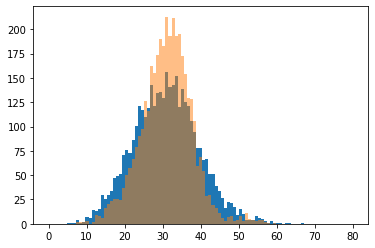

In [286]:
bins = np.linspace(0, 80, 100)


plt.hist(res_frp_do_08['frp'], bins)
plt.hist(res_frp_do_08.results, bins, alpha=0.5)
plt.show()

#### Более 75

In [490]:

cols = [
        
        'ctr',
        'depth',
       'category',
        'category_2',
      'all_sum',
        'dw', 
        'hour',
        

        'author_1',



       'words_text',
        'quotation marks_in_text',
        'mean_sentence_len', 'lexical_diversity',
        'labels_tags',
        'parag',
        'prirost_cat_14D',
        'category_in_24_hours'
     

        ]

cat_features = ['category', 'category_2',

        'dw', 'hour',
       
        'author_1', 
        'labels_tags'
       ]



In [500]:
model_cat = CatBoostRegressor(
    loss_function= 'RMSE',
    iterations=4000, 
    depth = 8,
    verbose=100, 
   cat_features=cat_features,
)

params = {'use_best_model' : True,
    'early_stopping_rounds' : 600}

    
target_col = 'full_reads_percent'
res, res_frp_after_08, imp_frp_after_08 = cross_val_kfold(train_frp_after_08, model_cat, params, cols, target_col, outlier_mask_frp_after_08)



Learning rate set to 0.024392
0:	learn: 9.7688512	test: 9.0943213	best: 9.0943213 (0)	total: 15.6ms	remaining: 1m 2s
100:	learn: 6.9118395	test: 6.6420504	best: 6.6420504 (100)	total: 4.15s	remaining: 2m 40s
200:	learn: 6.1972161	test: 6.3585112	best: 6.3585112 (200)	total: 8.04s	remaining: 2m 32s
300:	learn: 5.7418932	test: 6.2757865	best: 6.2754845 (298)	total: 11.9s	remaining: 2m 26s
400:	learn: 5.3589932	test: 6.2285798	best: 6.2285798 (400)	total: 15.7s	remaining: 2m 21s
500:	learn: 5.0135524	test: 6.2120125	best: 6.2120125 (500)	total: 19.1s	remaining: 2m 13s
600:	learn: 4.7073682	test: 6.1970635	best: 6.1970635 (600)	total: 21s	remaining: 1m 58s
700:	learn: 4.4269932	test: 6.1894099	best: 6.1857411 (674)	total: 22.9s	remaining: 1m 47s
800:	learn: 4.1794749	test: 6.1867014	best: 6.1848023 (750)	total: 24.8s	remaining: 1m 39s
900:	learn: 3.9467282	test: 6.1898575	best: 6.1848023 (750)	total: 26.8s	remaining: 1m 32s
1000:	learn: 3.7379361	test: 6.1988234	best: 6.1848023 (750)	total

In [501]:
res, np.mean(res)

([0.5452471587300669, 0.5599004209925607, 0.5923300678778771],
 0.5658258825335015)

In [502]:
train_frp = train_frp_after_08[~outlier_mask_frp_after_08]
res_frp_after_08['frp'] = train_frp['full_reads_percent'].reset_index(drop=True)
# res_frp['results'] = res_frp['results'].round(3)
r2_score(res_frp_after_08['frp'], res_frp_after_08['results'])

0.5670051414489143

In [503]:
imp_frp_after_08

fold_1  fold_1_imp                   fold_2  fold_2_imp  \
0                words_text   19.981952               words_text   21.610305   
1                      hour    9.856287                     hour   10.051947   
2                   all_sum    7.797423                  all_sum    7.974249   
3                     depth    7.602952          prirost_cat_14D    7.181547   
4                  category    7.383500                    depth    6.575782   
5                category_2    6.838264                 category    6.440743   
6                        dw    5.968195               category_2    6.325481   
7               labels_tags    5.656086                       dw    5.637380   
8           prirost_cat_14D    5.374338        lexical_diversity    4.683476   
9         lexical_diversity    4.807863              labels_tags    4.368419   
10     category_in_24_hours    4.048267                      ctr    3.916277   
11                 author_1    3.965001     category_in_24_hours    3.709017   
12                    parag    3.142114        mean_sentence_len    3.387491   
13        mean_sentence_len    2.764757                 author_1    2.978909   
14                      ctr    2.444745                    parag    2.620355   
15  quotation marks_in_text    2.368256  quotation marks_in_text    2.538624   

                     fold_3  fold_3_imp  
0                words_text   20.684512  
1                      hour   10.357396  
2                   all_sum    8.664387  
3                     depth    8.210481  
4                        dw    6.010893  
5                  category    5.800596  
6                category_2    5.753264  
7      category_in_24_hours    5.442195  
8           prirost_cat_14D    5.104220  
9         lexical_diversity    4.617213  
10              labels_tags    4.579814  
11                      ctr    4.127722  
12        mean_sentence_len    3.923864  
13                 author_1    2.690253  
14                    parag    2.291339  
15  quotation marks_in_text    1.741850

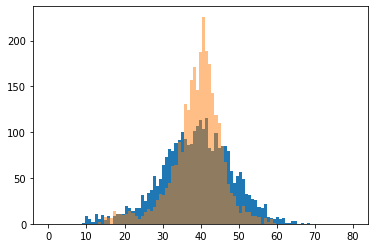

In [504]:
bins = np.linspace(0, 80, 100)

plt.hist(res_frp_after_08['frp'], bins)
plt.hist(res_frp_after_08.results, bins, alpha=0.5)
plt.show()

In [505]:
res_frp_all = pd.concat([res_frp_do_08, res_frp_after_08])
R2_frp = r2_score(res_frp_all['frp'],res_frp_all['results'])
R2_frp 

0.6525760207271364

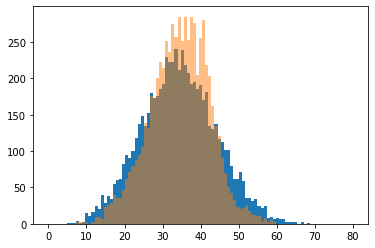

In [506]:
bins = np.linspace(0, 80, 100)

plt.hist(res_frp_all['frp'], bins)
plt.hist(res_frp_all.results, bins, alpha=0.5)
plt.show()

In [507]:
0.4*R2_views + 0.3*R2_depth + 0.3*R2_frp

0.7521751292529317

In [297]:
stop

NameError: ignored

# Test

## Depth

### До 75

In [508]:

cols = [
        'ctr',
       'category',
        'category_2',
        'dw', 'hour', 'count_name', 

        'author_1',
       'authors_count', 
       'foto_count', 'words_text',
        'quotation marks_in_text',
        'mean_sentence_len', 'lexical_diversity',

        'all_sum', 

        'labels_tags',
        ]

cat_features = [
                'category', 
                'category_2',
        'dw', 'hour',
        'author_1',
        'labels_tags',
        
       ]





In [509]:
x_train, y_train = train_do_08, train_do_08[['views', 'depth', 'full_reads_percent']]

In [510]:
target_col = 'depth'

model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=1600, 
  
    depth = 6,
                                      verbose=100, 
                                      cat_features=cat_features,
                                      )
model_cat.fit(x_train[cols],y_train[target_col],
)


res1 = model_cat.predict(test_do_08[cols])
test_do_08[target_col] = res1




Learning rate set to 0.034753
0:	learn: 0.0640694	total: 19.2ms	remaining: 30.8s
100:	learn: 0.0310365	total: 915ms	remaining: 13.6s
200:	learn: 0.0280471	total: 1.81s	remaining: 12.6s
300:	learn: 0.0263458	total: 2.78s	remaining: 12s
400:	learn: 0.0252397	total: 3.72s	remaining: 11.1s
500:	learn: 0.0244224	total: 4.63s	remaining: 10.2s
600:	learn: 0.0237064	total: 5.55s	remaining: 9.23s
700:	learn: 0.0230551	total: 6.45s	remaining: 8.28s
800:	learn: 0.0224719	total: 7.38s	remaining: 7.36s
900:	learn: 0.0218601	total: 8.28s	remaining: 6.42s
1000:	learn: 0.0211937	total: 9.18s	remaining: 5.49s
1100:	learn: 0.0206719	total: 10.1s	remaining: 4.58s
1200:	learn: 0.0201940	total: 11s	remaining: 3.66s
1300:	learn: 0.0197246	total: 11.9s	remaining: 2.74s
1400:	learn: 0.0192436	total: 12.9s	remaining: 1.82s
1500:	learn: 0.0187517	total: 13.7s	remaining: 907ms
1599:	learn: 0.0182766	total: 14.7s	remaining: 0us


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Более 75

In [511]:

cols = [
        'category_2',
        'dw', 'hour', 
        'words_text',
     'mean_sentence_len', 'lexical_diversity',
     'all_sum', 
   

    'labels_tags',
   

    

     

        ]

cat_features = [
                
                'category_2',

        'dw', 'hour',

        'labels_tags',
        

       ]

In [512]:
x_train, y_train = train_after_08, train_after_08[['views', 'depth', 'full_reads_percent']]

In [513]:
target_col = 'depth'

model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=1600, 
    # learning_rate = 0.003,
    # l2_leaf_reg = 0.1,
    depth = 6,
    verbose=100, 
    cat_features=cat_features,
)
model_cat.fit(x_train[cols],y_train[target_col],
)


res2 = model_cat.predict(test_after_08[cols])
test_after_08[target_col] = res2




Learning rate set to 0.033264
0:	learn: 0.0617178	total: 6.3ms	remaining: 10.1s
100:	learn: 0.0279249	total: 501ms	remaining: 7.44s
200:	learn: 0.0257446	total: 1.01s	remaining: 7.03s
300:	learn: 0.0240867	total: 1.55s	remaining: 6.68s
400:	learn: 0.0228668	total: 2.06s	remaining: 6.16s
500:	learn: 0.0219989	total: 2.57s	remaining: 5.64s
600:	learn: 0.0212380	total: 3.08s	remaining: 5.13s
700:	learn: 0.0206255	total: 3.63s	remaining: 4.65s
800:	learn: 0.0200440	total: 4.14s	remaining: 4.13s
900:	learn: 0.0194513	total: 4.66s	remaining: 3.62s
1000:	learn: 0.0189646	total: 5.18s	remaining: 3.1s
1100:	learn: 0.0184618	total: 5.69s	remaining: 2.58s
1200:	learn: 0.0179460	total: 6.21s	remaining: 2.06s
1300:	learn: 0.0175553	total: 6.72s	remaining: 1.54s
1400:	learn: 0.0171430	total: 7.24s	remaining: 1.03s
1500:	learn: 0.0167063	total: 7.78s	remaining: 513ms
1599:	learn: 0.0163032	total: 8.28s	remaining: 0us


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Views

### До 75

In [514]:

cols = ['ctr',
        'dw',
        'hour',
       'authors_count', 
        'count_tags', 
        'len_title_first', 
        'words',
       'foto_count',
        'words_text', 
        'all_sum',

        'labels_tags',

        


        
     

        ]

cat_features = [
        'dw', 
        'hour',
        'labels_tags',
        

       ]




In [515]:
x_train, y_train = train_do_08, train_do_08[['views', 'depth', 'full_reads_percent']]

In [516]:

target_col = 'views'

model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=2600, 
    depth = 6,
                                      verbose=100, 
                                      cat_features=cat_features,

                                      # leaf_estimation_method='Newton'
                                      )
model_cat.fit(x_train[cols],y_train[target_col],
)

res3 = model_cat.predict(test_do_08[cols])
test_do_08[target_col] = res3



Learning rate set to 0.023419
0:	learn: 120670.1910157	total: 5.25ms	remaining: 13.6s
100:	learn: 79941.0225304	total: 459ms	remaining: 11.4s
200:	learn: 66466.7208494	total: 952ms	remaining: 11.4s
300:	learn: 57988.5550627	total: 1.45s	remaining: 11.1s
400:	learn: 53143.9967437	total: 1.92s	remaining: 10.5s
500:	learn: 50148.6878674	total: 2.38s	remaining: 9.99s
600:	learn: 47212.7012915	total: 2.86s	remaining: 9.51s
700:	learn: 44843.6319427	total: 3.32s	remaining: 9s
800:	learn: 42603.4119392	total: 3.8s	remaining: 8.54s
900:	learn: 41074.2095833	total: 4.27s	remaining: 8.05s
1000:	learn: 39401.6011110	total: 4.74s	remaining: 7.58s
1100:	learn: 38432.4048166	total: 5.23s	remaining: 7.12s
1200:	learn: 37499.8685168	total: 5.71s	remaining: 6.65s
1300:	learn: 36391.3318964	total: 6.19s	remaining: 6.18s
1400:	learn: 35381.4980900	total: 6.67s	remaining: 5.71s
1500:	learn: 34695.4587813	total: 7.16s	remaining: 5.24s
1600:	learn: 34014.7170699	total: 7.67s	remaining: 4.78s
1700:	learn: 33

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Более 75

In [517]:


cols = [
        'ctr',

       'category',
        'category_2',

   
        'dw', 'hour', 
       'authors_count', 'count_tags', 
        'words',
        'quotation marks_in_text',
     'all_sum',

     'labels_tags',
   

        ]

cat_features = [
                'category', 
                'category_2',
        'dw', 'hour',

        'labels_tags',

       ]

In [518]:
x_train, y_train = train_after_08, train_after_08[['views', 'depth', 'full_reads_percent']]

In [519]:

target_col = 'views'

model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=1600, 
    depth = 10,
    verbose=100, 
    cat_features=cat_features,

    # leaf_estimation_method='Newton'
    )
model_cat.fit(x_train[cols],y_train[target_col],
)

res4 = model_cat.predict(test_after_08[cols])
test_after_08[target_col] = res4



Learning rate set to 0.033264
0:	learn: 34491.8090911	total: 30.2ms	remaining: 48.3s
100:	learn: 21220.6611594	total: 2.01s	remaining: 29.8s
200:	learn: 17139.0707786	total: 4.19s	remaining: 29.2s
300:	learn: 14856.0453227	total: 6.43s	remaining: 27.8s
400:	learn: 13265.3560415	total: 9.07s	remaining: 27.1s
500:	learn: 11824.9534610	total: 11.8s	remaining: 25.9s
600:	learn: 10752.6578957	total: 14.4s	remaining: 24s
700:	learn: 9737.0753918	total: 17.1s	remaining: 22s
800:	learn: 8852.3811703	total: 19.8s	remaining: 19.8s
900:	learn: 8080.3565151	total: 22.5s	remaining: 17.5s
1000:	learn: 7378.3740499	total: 27.4s	remaining: 16.4s
1100:	learn: 6720.7510270	total: 30.1s	remaining: 13.7s
1200:	learn: 6147.0265375	total: 32.8s	remaining: 10.9s
1300:	learn: 5595.0897684	total: 35.5s	remaining: 8.15s
1400:	learn: 5198.2095719	total: 38.1s	remaining: 5.42s
1500:	learn: 4792.8231186	total: 40.7s	remaining: 2.69s
1599:	learn: 4441.3039815	total: 43.4s	remaining: 0us


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## FRP

### До 75

In [520]:
cols = ['ctr',
        'depth',

       'category',
        'category_2',
    'all_sum',
        'dw', 'hour', 'count_name', 

        'author_1',
 
       'foto_count', 'words_text', 
        'mean_sentence_len', 'lexical_diversity',
        'labels_tags',
        'parag',
'prirost_cat_14D',
        'category_in_24_hours'
        
     

        ]

cat_features = ['category', 
                'category_2',
   
        'dw', 'hour',
       
        'author_1',
 
        'labels_tags',


        

       ]


In [521]:
x_train, y_train = train_frp_do_08, train_frp_do_08[['views', 'depth', 'full_reads_percent']]

In [522]:
target_col = 'full_reads_percent'

model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=3200, 
    # learning_rate = 0.003,
    # l2_leaf_reg = 0.1,
    depth = 6,
                                      verbose=100, 
                                      cat_features=cat_features,

                                      # leaf_estimation_method='Newton'
                                      )
model_cat.fit(x_train[cols],y_train[target_col],
)

res5 = model_cat.predict(test_do_08[cols])
test_do_08[target_col] = res5

Learning rate set to 0.01978
0:	learn: 9.1110639	total: 10.2ms	remaining: 32.6s
100:	learn: 6.7999714	total: 962ms	remaining: 29.5s
200:	learn: 6.2787181	total: 1.92s	remaining: 28.7s
300:	learn: 6.0166143	total: 2.83s	remaining: 27.3s
400:	learn: 5.8352405	total: 3.74s	remaining: 26.1s
500:	learn: 5.6502236	total: 4.67s	remaining: 25.2s
600:	learn: 5.5020336	total: 5.96s	remaining: 25.8s
700:	learn: 5.3733628	total: 7.42s	remaining: 26.4s
800:	learn: 5.2610314	total: 8.39s	remaining: 25.1s
900:	learn: 5.1537360	total: 9.37s	remaining: 23.9s
1000:	learn: 5.0565554	total: 10.3s	remaining: 22.7s
1100:	learn: 4.9625671	total: 11.3s	remaining: 21.6s
1200:	learn: 4.8775045	total: 12.3s	remaining: 20.4s
1300:	learn: 4.8017522	total: 13.3s	remaining: 19.3s
1400:	learn: 4.7304027	total: 14.2s	remaining: 18.3s
1500:	learn: 4.6618305	total: 15.2s	remaining: 17.2s
1600:	learn: 4.5931369	total: 16.2s	remaining: 16.1s
1700:	learn: 4.5267151	total: 17.1s	remaining: 15.1s
1800:	learn: 4.4627573	total

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### После 08

In [523]:

cols = [
        
        'ctr',
        'depth',

        
       

       'category',
        'category_2',

  
      'all_sum',
        'dw', 
        'hour',
        

        'author_1',
 


       'words_text',
        'quotation marks_in_text',
        'mean_sentence_len', 'lexical_diversity',
      
        'labels_tags',
        'parag',

        'prirost_cat_14D',
        'category_in_24_hours'
     

        ]

cat_features = ['category', 'category_2',
     
        'dw', 'hour',
        
        'author_1',  
   
        'labels_tags',


        

       ]




In [524]:
x_train, y_train = train_frp_after_08, train_frp_after_08[['views', 'depth', 'full_reads_percent']]

In [525]:
target_col = 'full_reads_percent'

model_cat = CatBoostRegressor(random_state = 1433,
    loss_function= 'RMSE',
    iterations=1200, 
    # learning_rate = 0.003,
    # l2_leaf_reg = 0.1,
    depth = 8,
                                      verbose=100, 
                                      cat_features=cat_features,

                                      # leaf_estimation_method='Newton'
                                      )
model_cat.fit(x_train[cols],y_train[target_col],
)

res6 = model_cat.predict(test_after_08[cols])
test_after_08[target_col] = res6

Learning rate set to 0.04203
0:	learn: 9.6427521	total: 19.5ms	remaining: 23.3s
100:	learn: 6.4862018	total: 1.95s	remaining: 21.2s
200:	learn: 5.8458290	total: 3.93s	remaining: 19.5s
300:	learn: 5.3352819	total: 5.96s	remaining: 17.8s
400:	learn: 4.8900649	total: 8.01s	remaining: 16s
500:	learn: 4.5293833	total: 10.1s	remaining: 14.1s
600:	learn: 4.1957704	total: 12.2s	remaining: 12.2s
700:	learn: 3.9163335	total: 14.3s	remaining: 10.2s
800:	learn: 3.6161741	total: 16.4s	remaining: 8.15s
900:	learn: 3.3861372	total: 18.4s	remaining: 6.12s
1000:	learn: 3.1754363	total: 20.5s	remaining: 4.07s
1100:	learn: 2.9820339	total: 22.5s	remaining: 2.03s
1199:	learn: 2.7948703	total: 24.6s	remaining: 0us


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [526]:
test_all = pd.concat([test_do_08, test_after_08])
test_all = test_all.sort_index()


solution['depth'] = test_all['depth']
solution['views'] = test_all['views']
solution['full_reads_percent'] = test_all['full_reads_percent']

In [527]:
solution.loc[solution['views']<0, 'views'] = train['views'].min()

solution['views'] = solution['views'].round()
solution['depth'] = solution['depth'].round(3)
solution['full_reads_percent'] = solution['full_reads_percent'].round(3)

In [528]:
solution.to_csv('53.csv', index=False)

In [529]:
solution

document_id     views  depth  \
0     61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw   28953.0  1.203   
1     628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw    3516.0  1.072   
2     627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw   11294.0  1.058   
3     628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ    6932.0  1.071   
4     620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw  109638.0  1.138   
...                                              ...       ...    ...   
2995  623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg   44029.0  1.138   
2996  624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ   45442.0  1.138   
2997  6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww    7362.0  1.064   
2998  624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw   11187.0  1.177   
2999  6236f9129a79477b0ef18ae0ewByZQ1FQBK2dpXyY77rYw   13786.0  1.155   

      full_reads_percent  
0                 43.395  
1                 34.176  
2                 28.650  
3                 34.031  
4                 31.330  
...                  ...  
2995              34.119  
2996              37.025  
2997              43.460  
2998              42.385  
2999              38.521  

[3000 rows x 4 columns]